In [618]:
# Import required Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import plotly.graph_objs as go
from collections import defaultdict

In [402]:
# Synchrony Color Palette
synchrony = ['#FBC600', '#3B3D49']


In [376]:
# Function to create unified dataset
def read_files():
    files = ['dataset/file_3_Mar18_Output_1_1.csv', 
             'dataset/file_3_Mar18_Output_1_2.csv', 
             'dataset/file_3_Mar18_Output_1_3.csv', 
             'dataset/file_3_Mar18_Output_1_4.csv', 
             'dataset/file_3_Mar18_Output_1_5.csv', 
             'dataset/file_3_Mar18_Output_1_6.csv', 
             'dataset/file_4_Mar18_Output_1_1.csv', 
             'dataset/file_4_Mar18_Output_1_2.csv', 
             'dataset/file_4_Mar18_Output_1_3.csv', 
             'dataset/file_4_Mar18_Output_1_4.csv', 
             'dataset/file_4_Mar18_Output_1_5.csv', 
             'dataset/file_4_Mar18_Output_1_6.csv']
    data = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        data = pd.concat([data, df])
    return data

In [377]:
# Import main dataset
data = read_files()

In [379]:
# Import data dictionary to map 'mos' column
xl = pd.ExcelFile('dataset/U of I IVR code data dictionary(updated).xlsx')
mos_sheet = xl.parse('mos')
external_status = xl.parse('external_status')
ebill_ind = xl.parse('ebill_ind')
card_activation_flag = xl.parse('card_activation_flag')

# Print headers to verify content
mos_sheet.head(), external_status.head(), ebill_ind.head() ,card_activation_flag.head()


(  Code IVR Call Reason for IVR Call Reporting
 0   AA                             Activation
 1   AG                 Transferred from agent
 2   AL                         Account lookup
 3   AP                   Address phone change
 4   AR                        APR Information,
   code           external_status
 0    A  Authorization prohibited
 1    B                  Bankrupt
 2    C                    Closed
 3    E                   Revoked
 4    F                    Frozen,
   code ebill_ind (EBP Participation Indicator Code.)
 0    D                                           NaN
 1                        Does Not participate in EBP
 2    L     Hard Copy and Electronic statement always
 3    C                                           NaN
 4    0                                           NaN,
                       code                               card_activation_flag
 0                        0                                          activated
 1                           

In [108]:
# Visualize 'mos' column of dataset
data['mos'].head()

0                IA PP TR
1          IA BA TS nl TR
2    IA AA BA MR nl PT TR
3                   IA BA
4       IA BA TS nl mm TR
Name: mos, dtype: object

In [380]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   timestamp_call_key                 object 
 1   retailer_code                      object 
 2   serial                             int64  
 3   reason                             object 
 4   mos                                object 
 5   resolved                           object 
 6   no_of_accounts_with_syf_13_march   float64
 7   account_balance_13_march           float64
 8   delinquency_history_13_march       object 
 9   account_open_date_13_march         object 
 10  account_status_13_march            object 
 11  card_activation_status_13_march    object 
 12  eservice_ind_13_march              int64  
 13  ebill_enrolled_status_13_march     object 
 14  auto_pay_enrolled_status_13_march  int64  
 15  no_of_accounts_with_syf_18_march   float64
 16  account_balance_18_

In [382]:
model_data = pd.DataFrame()
model_data['reason'] = data['reason'].astype('category')

## **Data Cleaning**

In [383]:
data["resolved"].isnull().sum()

0

In [399]:
resolved_counts = pd.DataFrame(data["resolved"].value_counts().sort_values(ascending=False))
resolved_counts

,resolved
resolved,1432581
floor,366217


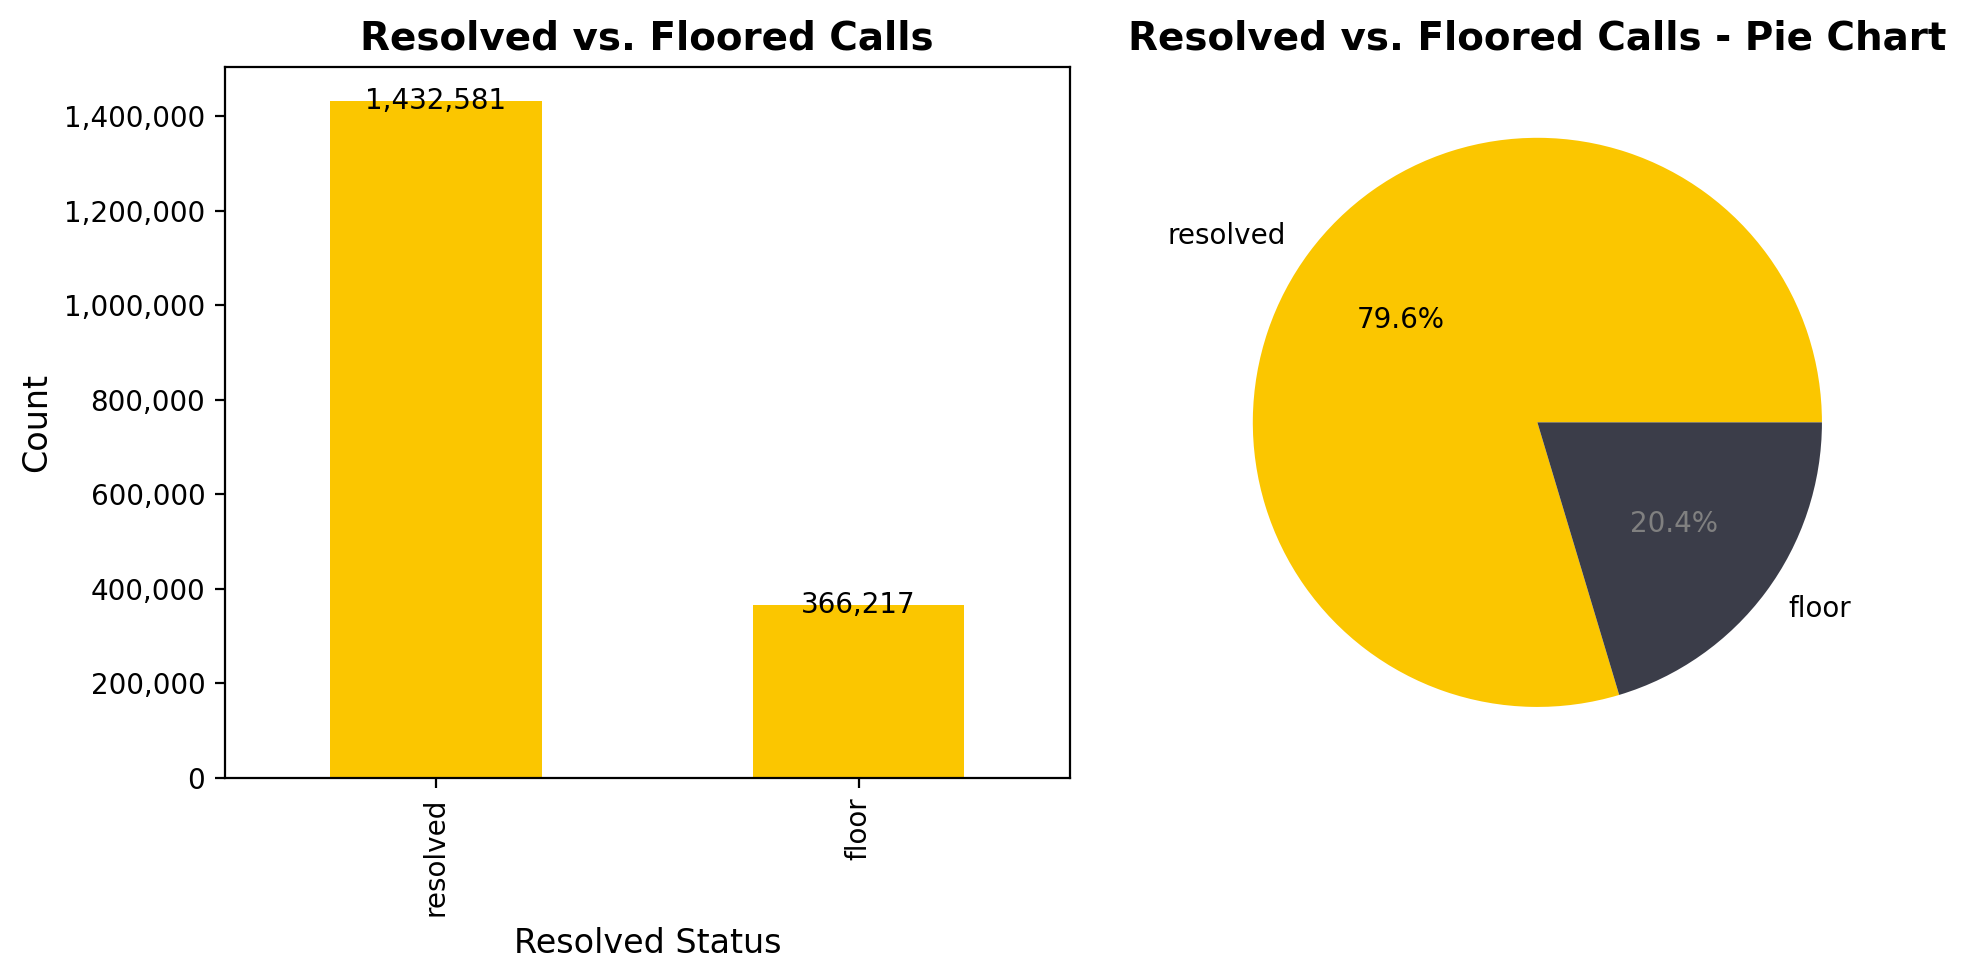

In [404]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# Bar plot
ax = resolved_counts.plot(kind='bar', color=synchrony[0], legend=False, ax=axs[0])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis to display real numbers with commas
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black')  # Center the annotation
ax.set_title('Resolved vs. Floored Calls', fontsize=14, fontweight='bold')
ax.set_xlabel('Resolved Status', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Pie chart
ax = resolved_counts.plot(kind='pie', y=resolved_counts.columns[0], autopct='%1.1f%%', legend=False, ax=axs[1], colors=synchrony)
ax.set_title('Resolved vs. Floored Calls - Pie Chart', fontsize=14, fontweight='bold')
ax.set_ylabel('')  # Hide y-axis label

# Create an iterator for the colors
colors = itertools.cycle(['black', 'grey'])

# Change the color of the percentage labels
for text in ax.texts:
    if '%' in text.get_text():
        text.set_color(next(colors))

plt.tight_layout()
plt.show()

In [405]:
model_data["resolved"] = data["resolved"]

In [406]:
data["reason"].isnull().sum()

0

In [410]:
reason_count = pd.DataFrame(data["reason"].value_counts().sort_values(ascending=False)).reset_index()
reason_count.columns = ['reason', 'reason_count']
reason_count['reason_%'] = ((reason_count['reason_count'] / len(data)) * 100).round(4)
reason_count['cummulative_%'] = reason_count['reason_%'].cumsum()

# The table below just shows the real reasons for the calls (using the mos dictionary). These are ordered descendingly.
reason_count = reason_count.merge(mos_sheet, left_on='reason', right_on='Code', how='left')
reason_count.head(20)

,reason,reason_count,reason_%,cummulative_%,Code,IVR Call Reason for IVR Call Reporting
0,PP,678314,37.7093,37.7093,PP,PBP Predictive
1,BA,566351,31.4850,69.1943,BA,Account Summary
2,PT,221583,12.3184,81.5127,PT,PBP Request
3,AT,91404,5.0814,86.5941,AT,Account transactions
4,AA,54861,3.0499,89.6440,AA,Activation
5,CT,23796,1.3229,90.9669,CT,CIT Change in Terms
6,wa,14296,0.7948,91.7617,wa,Request waiver
7,LS,13765,0.7652,92.5269,LS,Report lost stolen
8,FD,13007,0.7231,93.2500,FD,Fraud detect
9,LC,10076,0.5602,93.8102,LC,Live chat


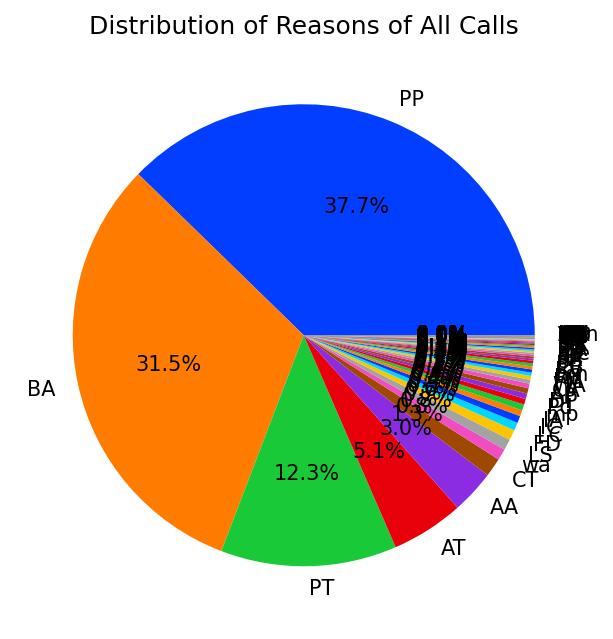

In [425]:
colors = sns.color_palette("bright", len(reason_count))

plt.figure(figsize=(5, 5), dpi=150)
ax = reason_count["reason_count"].plot(
    kind='pie',
    labels=reason_count["reason"],
    autopct='%1.1f%%',
    colors=colors
)
# Add a title
ax.set_title('Distribution of Reasons of All Calls')
ax.set_ylabel('')

plt.show()

In [428]:
UNRESOLVED_calls = data[data["resolved"] == "floor"]
UNRESOLVED_calls.shape #(366217, 24)  

(366217, 24)

In [431]:
UNRESOLVED_reason_count = pd.DataFrame(UNRESOLVED_calls["reason"].value_counts().sort_values(ascending=False)).reset_index()
UNRESOLVED_reason_count.columns = ['reason', 'reason_count']
UNRESOLVED_reason_count['reason_%'] = ((UNRESOLVED_reason_count['reason_count'] / len(UNRESOLVED_calls)) * 100).round(4)
UNRESOLVED_reason_count['cummulative_%'] = UNRESOLVED_reason_count['reason_%'].cumsum()

# The table below just shows the real reasons for the calls (using the mos dictionary). These are ordered descendingly.
UNRESOLVED_reason_count = UNRESOLVED_reason_count.merge(mos_sheet, left_on='reason', right_on='Code', how='left')
UNRESOLVED_reason_count.head(20)

,reason,reason_count,reason_%,cummulative_%,Code,IVR Call Reason for IVR Call Reporting
0,BA,158394,43.2514,43.2514,BA,Account Summary
1,PP,33562,9.1645,52.4159,PP,PBP Predictive
2,CT,23082,6.3028,58.7187,CT,CIT Change in Terms
3,PT,18309,4.9995,63.7182,PT,PBP Request
4,AA,15089,4.1202,67.8384,AA,Activation
5,wa,13248,3.6175,71.4559,wa,Request waiver
6,FD,12474,3.4062,74.8621,FD,Fraud detect
7,LS,9482,2.5892,77.4513,LS,Report lost stolen
8,AT,8687,2.3721,79.8234,AT,Account transactions
9,LC,7582,2.0704,81.8938,LC,Live chat


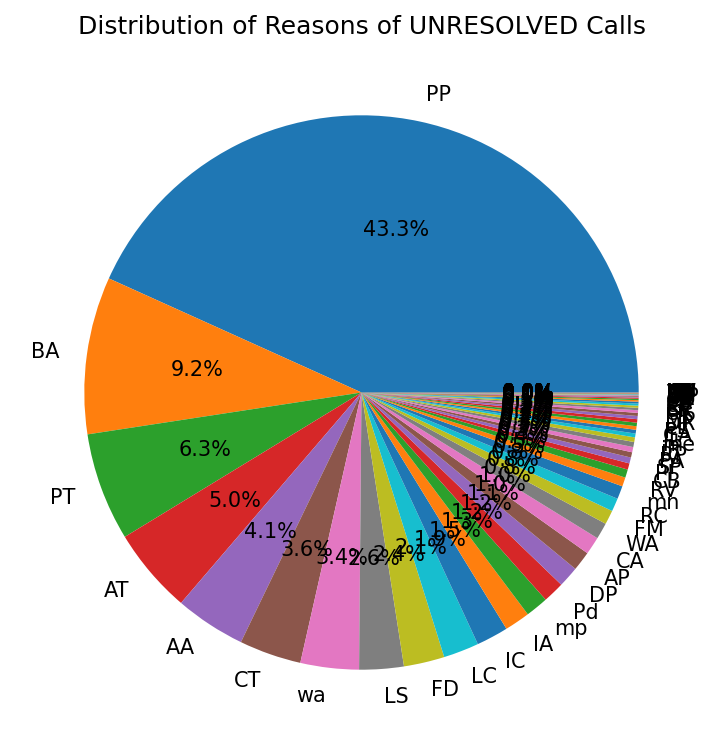

In [433]:
plt.figure(figsize=(6, 6), dpi=150)
ax = UNRESOLVED_reason_count["reason_count"].plot(kind='pie', labels=reason_count["reason"], autopct='%1.1f%%')

# Add a title
ax.set_title('Distribution of Reasons of UNRESOLVED Calls')
ax.set_ylabel('')

plt.show()

In [435]:
data["retailer_code"].isnull().sum()

0

In [438]:
retailer_count = pd.DataFrame(data["retailer_code"].value_counts().sort_values(ascending=False)).reset_index()
retailer_count.columns = ['retailer_code', 'retailer_count']
retailer_count['retailer_%'] = ((retailer_count['retailer_count'] / len(data)) * 100).round(4)
retailer_count.head(20)

,retailer_code,retailer_count,retailer_%
0,a,229442,12.7553
1,B,198320,11.0251
2,A,188241,10.4648
3,D,171362,9.5265
4,b,168005,9.3398
5,C,126941,7.0570
6,E,101345,5.6340
7,d,94085,5.2304
8,c,88524,4.9213
9,g,62781,3.4902


In [440]:
model_data["retailer_code"] = data["retailer_code"]
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 3 columns):
 #   Column         Dtype   
---  ------         -----   
 0   reason         category
 1   resolved       object  
 2   retailer_code  object  
dtypes: category(1), object(2)
memory usage: 42.9+ MB


In [441]:
data["no_of_accounts_with_syf_13_march"].value_counts(dropna=False).sort_values(ascending=False)

2.0     271179
3.0     263280
4.0     232315
1.0     226210
5.0     191677
         ...  
45.0         2
47.0         1
57.0         1
54.0         1
55.0         1
Name: no_of_accounts_with_syf_13_march, Length: 62, dtype: int64

In [442]:
data["no_of_accounts_with_syf_13_march"].isnull().sum()

3400

In [443]:
model_data["no_of_accounts_with_syf_13_march"] = data["no_of_accounts_with_syf_13_march"]

In [444]:
print(data["no_of_accounts_with_syf_18_march"].isnull().sum())
model_data["no_of_accounts_with_syf_18_march"] = data["no_of_accounts_with_syf_18_march"]

3402


In [445]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 5 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
dtypes: category(1), float64(2), object(2)
memory usage: 70.3+ MB


In [446]:
data["account_balance_13_march"].isnull().sum()

113782

In [447]:
data["account_balance_13_march"].describe()

count    1.685016e+06
mean     1.317626e+03
std      1.972779e+03
min     -2.559600e+04
25%      1.149700e+02
50%      5.715850e+02
75%      1.716582e+03
max      5.864171e+04
Name: account_balance_13_march, dtype: float64

In [448]:
model_data["account_balance_13_march"] = data["account_balance_13_march"]

In [449]:
print(data["account_balance_18_march"].isnull().sum())

101829


In [450]:
print(data["account_balance_18_march"].isnull().sum())
model_data["account_balance_18_march"] = data["account_balance_18_march"]

101829


In [451]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 7 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
 5   account_balance_13_march          float64 
 6   account_balance_18_march          float64 
dtypes: category(1), float64(4), object(2)
memory usage: 97.8+ MB


In [452]:
data["delinquency_history_13_march"].isnull().sum()

0

In [454]:
data["delinquency_history_13_march"].describe()


count     1798798
unique         45
top          [00]
freq      1660525
Name: delinquency_history_13_march, dtype: object

In [455]:
model_data[['delinquency_13_first_digit', 'delinquency_13_second_digit']] = data["delinquency_history_13_march"].str.extract(r'\[(\d)(\d)\]')
model_data[['delinquency_13_first_digit', 'delinquency_13_second_digit']].astype(int)

,delinquency_13_first_digit,delinquency_13_second_digit
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
144160,0,0
144161,0,0
144162,0,0
144163,0,0


In [456]:
model_data[['delinquency_18_first_digit', 'delinquency_18_second_digit']] = data["delinquency_history_18_march"].str.extract(r'\[(\d)(\d)\]')
model_data[['delinquency_18_first_digit', 'delinquency_18_second_digit']].astype(int)

,delinquency_18_first_digit,delinquency_18_second_digit
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
144160,0,0
144161,0,0
144162,0,0
144163,0,0


In [457]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 11 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
 5   account_balance_13_march          float64 
 6   account_balance_18_march          float64 
 7   delinquency_13_first_digit        object  
 8   delinquency_13_second_digit       object  
 9   delinquency_18_first_digit        object  
 10  delinquency_18_second_digit       object  
dtypes: category(1), float64(4), object(6)
memory usage: 152.7+ MB


In [458]:
data[['account_open_date_13_march', 'account_open_date_18_march']]

,account_open_date_13_march,account_open_date_18_march
0,5/19/2013,5/19/2013
1,9/22/2003,9/22/2003
2,9/4/2017,9/4/2017
3,2/7/2024,2/7/2024
4,1/2/2022,1/2/2022
...,...,...
144160,2/8/2022,2/8/2022
144161,2/8/2022,2/8/2022
144162,8/24/2023,8/24/2023
144163,5/15/2019,5/15/2019


In [459]:
(data['account_open_date_13_march'] == data['account_open_date_18_march']).value_counts()

True     1798796
False          2
dtype: int64

In [460]:
data[['account_open_date_13_march', 'account_open_date_18_march']][data['account_open_date_13_march'] != data['account_open_date_18_march']]

,account_open_date_13_march,account_open_date_18_march
54611,3/8/2024,2/7/2022
44677,3/10/2024,10/11/2021


In [461]:
data['account_open_date_13_march'] = pd.to_datetime(data['account_open_date_13_march'])
data['account_open_date_18_march'] = pd.to_datetime(data['account_open_date_18_march'])

In [462]:
data[['account_open_date_13_march', 'account_open_date_18_march']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 2 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   account_open_date_13_march  datetime64[ns]
 1   account_open_date_18_march  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 41.2 MB


In [464]:
model_data['days_since_account_open_13'] = (pd.Timestamp('2024-03-13') - data['account_open_date_13_march']).dt.days
model_data['days_since_account_open_18'] = (pd.Timestamp('2024-03-18') - data['account_open_date_18_march']).dt.days

In [465]:
model_data[['days_since_account_open_13', 'days_since_account_open_18']]

,days_since_account_open_13,days_since_account_open_18
0,3951,3956
1,7478,7483
2,2382,2387
3,35,40
4,801,806
...,...,...
144160,764,769
144161,764,769
144162,202,207
144163,1764,1769


In [466]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 13 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
 5   account_balance_13_march          float64 
 6   account_balance_18_march          float64 
 7   delinquency_13_first_digit        object  
 8   delinquency_13_second_digit       object  
 9   delinquency_18_first_digit        object  
 10  delinquency_18_second_digit       object  
 11  days_since_account_open_13        int64   
 12  days_since_account_open_18        int64   
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 180.1+ MB


In [467]:
data["account_status_13_march"].isnull().sum() 

1732768

In [468]:
model_data["account_status_13_march"] = data["account_status_13_march"].astype(str)

In [469]:
model_data["account_status_13_march"].value_counts()

nan    1732768
E        39261
C         7736
F         7015
A         6182
Z         3674
L         1430
U          366
I          320
B           46
Name: account_status_13_march, dtype: int64

We can also encode other status: 
* C,E,F, I, Z   as "Closed"
* L, S          as "Lost/Stolen"


U is a typo, it really means S

In [470]:
model_data["account_status_13_march"] = model_data["account_status_13_march"].replace("nan", "Open") \
    .replace(["C", "E", "F", "I", "Z"], "Closed") \
    .replace(["B"], "Bankrupt") \
    .replace(["L", "U"], "Lost/Stolen") \
    .replace(["A"], "Hold")

model_data["account_status_13_march"].value_counts()

Open           1732768
Closed           58006
Hold              6182
Lost/Stolen       1796
Bankrupt            46
Name: account_status_13_march, dtype: int64

In [471]:
data["account_status_18_march"].isnull().sum() 

1703450

In [472]:
model_data["account_status_18_march"] = data["account_status_18_march"].astype(str)

In [473]:
model_data["account_status_18_march"] = model_data["account_status_18_march"].replace("nan", "Open") \
    .replace(["C", "E", "F", "I", "Z"], "Closed") \
    .replace(["B"], "Bankrupt") \
    .replace(["L", "U"], "Lost/Stolen") \
    .replace(["A"], "Hold")

model_data["account_status_18_march"].value_counts()

Open           1703450
Closed           69462
Lost/Stolen      17968
Hold              7857
Bankrupt            61
Name: account_status_18_march, dtype: int64

In [474]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 15 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
 5   account_balance_13_march          float64 
 6   account_balance_18_march          float64 
 7   delinquency_13_first_digit        object  
 8   delinquency_13_second_digit       object  
 9   delinquency_18_first_digit        object  
 10  delinquency_18_second_digit       object  
 11  days_since_account_open_13        int64   
 12  days_since_account_open_18        int64   
 13  account_status_13_march           object  
 14  account_status_18_march           object  
dtypes: category(1), float64(4), int64(2), object(8)
memory usage: 207.6

##### **Remark:**
We can also explore how similar this attribute is at both "dates".

In [475]:
model_data[["account_status_13_march", "account_status_18_march"]]

,account_status_13_march,account_status_18_march
0,Open,Open
1,Open,Open
2,Open,Open
3,Open,Open
4,Open,Open
...,...,...
144160,Open,Open
144161,Open,Open
144162,Open,Open
144163,Hold,Hold


In [476]:
(model_data['account_status_13_march'] == model_data['account_status_18_march']).value_counts()

True     1764706
False      34092
dtype: int64

#### **Card Activation Status**

We assume that since this is provided by Synchrony and not the customer, there are no NaNs. The blanks mean that that account does not have a card activation status

In [477]:
print(data['card_activation_status_13_march'].isnull().sum())
print(data['card_activation_status_18_march'].isnull().sum())  

data["card_activation_status_13_march"].value_counts()

0
0


0    1646276
8      67626
7      59622
       25274
Name: card_activation_status_13_march, dtype: int64

In [478]:
model_data["card_activation_status_13_march"] = data["card_activation_status_13_march"].astype(str)
model_data["card_activation_status_13_march"].value_counts()

0    1646276
8      67626
7      59622
       25274
Name: card_activation_status_13_march, dtype: int64

We can encode these variables as: 
* 0- Activated, 
* 7- New Account number not activated, 
* 8-Same Account number not activated 
* 9- Activated today (pending)

In [483]:
model_data["card_activation_status_13_march"] = model_data["card_activation_status_13_march"].replace({
    "0": "Activate",
    "7": "New Not",
    "8": "Same Not",
    "9": "Today/Pending"
})

# Encode all other values that are not "0", "7", "8", "9" as "100"
model_data.loc[~model_data["card_activation_status_13_march"].isin(["Activate", "New Not", "Same Not", "Today/Pending"]), "card_activation_status_13_march"] = "100/No acc. Status"
model_data["card_activation_status_13_march"].value_counts()

Activate              1646276
Same Not                67626
New Not                 59622
100/No acc. Status      25274
Name: card_activation_status_13_march, dtype: int64

In [485]:
model_data["card_activation_status_18_march"] = data["card_activation_status_18_march"].astype(str)
model_data["card_activation_status_18_march"] = model_data["card_activation_status_18_march"].replace({
    "0": "Activate",
    "7": "New Not",
    "8": "Same Not",
    "9": "Today/Pending"
})

# Encode all other values that are not "0", "7", "8", "9" as "100"
model_data.loc[~model_data["card_activation_status_18_march"].isin(["Activate", "New Not", "Same Not", "Today/Pending"]), "card_activation_status_18_march"] = "100/No acc. Status"
model_data["card_activation_status_18_march"].value_counts()

Activate              1637111
Same Not                82043
New Not                 54651
100/No acc. Status      24993
Name: card_activation_status_18_march, dtype: int64

In [486]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 17 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   reason                            category
 1   resolved                          object  
 2   retailer_code                     object  
 3   no_of_accounts_with_syf_13_march  float64 
 4   no_of_accounts_with_syf_18_march  float64 
 5   account_balance_13_march          float64 
 6   account_balance_18_march          float64 
 7   delinquency_13_first_digit        object  
 8   delinquency_13_second_digit       object  
 9   delinquency_18_first_digit        object  
 10  delinquency_18_second_digit       object  
 11  days_since_account_open_13        int64   
 12  days_since_account_open_18        int64   
 13  account_status_13_march           object  
 14  account_status_18_march           object  
 15  card_activation_status_13_march   object  
 16  card_activation_sta

#### **E-service ind**
With this feature, just as with Card Activation Status, there are no NaNs.

In [488]:
print(data["eservice_ind_13_march"].isnull().sum())
print(data["eservice_ind_18_march"].isnull().sum())

0
0


In [491]:
model_data["eservice_ind_13_march"] = data["eservice_ind_13_march"].astype(int)
model_data["eservice_ind_18_march"] = data["eservice_ind_18_march"].astype(int)
model_data["eservice_ind_13_march"].value_counts()

0    1205973
1     592825
Name: eservice_ind_13_march, dtype: int64

#### **Ebill ind**

* Blankss: paper statements.
* B, D, L : both
* E: electronic only


In [492]:
model_data["ebill_enrolled_status_13_march"] = data["ebill_enrolled_status_13_march"].astype(str)
model_data["ebill_enrolled_status_18_march"] = data["ebill_enrolled_status_18_march"].astype(str)
model_data["ebill_enrolled_status_13_march"].value_counts()

       943900
E      508389
L      305433
B       32084
nan      4936
D        4056
Name: ebill_enrolled_status_13_march, dtype: int64

In [493]:
model_data["ebill_enrolled_status_13_march"] = model_data["ebill_enrolled_status_13_march"].replace(["E"], "Electronic") \
    .replace(["B", "D", "L"], "Both")
model_data.loc[~model_data["ebill_enrolled_status_13_march"].isin(["Electronic", "Both"]), "ebill_enrolled_status_13_march"] = "Paper"


model_data["ebill_enrolled_status_18_march"] = model_data["ebill_enrolled_status_18_march"].replace(["E"], "Electronic") \
    .replace(["B", "D", "L"], "Both")
model_data.loc[~model_data["ebill_enrolled_status_18_march"].isin(["Electronic", "Both"]), "ebill_enrolled_status_18_march"] = "Paper"

model_data["ebill_enrolled_status_13_march"].value_counts()

Paper         948836
Electronic    508389
Both          341573
Name: ebill_enrolled_status_13_march, dtype: int64

In [494]:
print(data["auto_pay_enrolled_status_13_march"].isnull().sum())
print(data["auto_pay_enrolled_status_18_march"].isnull().sum())

0
0


In [495]:
model_data["auto_pay_enrolled_status_13_march"] = data["auto_pay_enrolled_status_13_march"].astype(int)
model_data["auto_pay_enrolled_status_18_march"] = data["auto_pay_enrolled_status_18_march"].astype(int)

In [498]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 23 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   reason                             category
 1   resolved                           object  
 2   retailer_code                      object  
 3   no_of_accounts_with_syf_13_march   float64 
 4   no_of_accounts_with_syf_18_march   float64 
 5   account_balance_13_march           float64 
 6   account_balance_18_march           float64 
 7   delinquency_13_first_digit         object  
 8   delinquency_13_second_digit        object  
 9   delinquency_18_first_digit         object  
 10  delinquency_18_second_digit        object  
 11  days_since_account_open_13         int64   
 12  days_since_account_open_18         int64   
 13  account_status_13_march            object  
 14  account_status_18_march            object  
 15  card_activation_status_13_march    object  
 16  c

In [499]:
data["timestamp_call_key"].head()

0    240315173250 DAL1OA3M
1    240315124742 DAL15XHK
2    240317114237 DAL3BLK6
3    240314120849 PHX6PL4U
4    240314145902 DAL68RYS
Name: timestamp_call_key, dtype: object

We extract the first 12 characters as YEAR, MONTH, DAY, HOUR, MINUTE, SECOND:

In [500]:
model_data["timestamp_call_key"] = pd.to_datetime(data['timestamp_call_key'].str[:12], format='%y%m%d%H%M%S')
model_data["timestamp_call_key"].head()

0   2024-03-15 17:32:50
1   2024-03-15 12:47:42
2   2024-03-17 11:42:37
3   2024-03-14 12:08:49
4   2024-03-14 14:59:02
Name: timestamp_call_key, dtype: datetime64[ns]

#### Serial

We use this for ID purposes only

In [501]:
model_data["serial"] = data["serial"]
model_data["serial"].head()

0    10010009499
1    10006021998
2    10016007830
3    10008003199
4    10013002037
Name: serial, dtype: int64

#### MOS
For now, I will model this feature considering only its length, and add it to the model_data DataFrame

In [502]:
data["mos"]

0                              IA PP TR
1                        IA BA TS nl TR
2                  IA AA BA MR nl PT TR
3                                 IA BA
4                     IA BA TS nl mm TR
                      ...              
144160                      IA BA TA nl
144161                            IA BA
144162                         IA PP TR
144163                         IA IA TR
144164    IA AA BA TS nl LS nl nl LS TR
Name: mos, Length: 1798798, dtype: object

In [503]:
model_data["mos_length"] = data['mos'].str.split().apply(len)
model_data["mos_length"].value_counts()

3     635670
4     298066
6     183860
7     174635
2     140124
5     136828
8     109475
9      60460
10     31857
11     27539
1        284
Name: mos_length, dtype: int64

#### **Correlation Between Attributes**

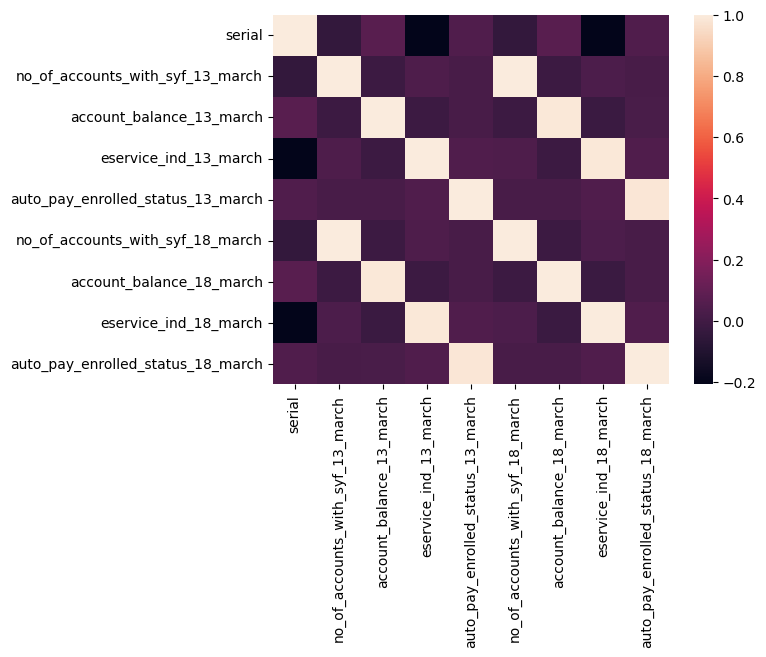

In [504]:
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()

### **Models**

In [505]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798798 entries, 0 to 144164
Data columns (total 26 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   reason                             category      
 1   resolved                           object        
 2   retailer_code                      object        
 3   no_of_accounts_with_syf_13_march   float64       
 4   no_of_accounts_with_syf_18_march   float64       
 5   account_balance_13_march           float64       
 6   account_balance_18_march           float64       
 7   delinquency_13_first_digit         object        
 8   delinquency_13_second_digit        object        
 9   delinquency_18_first_digit         object        
 10  delinquency_18_second_digit        object        
 11  days_since_account_open_13         int64         
 12  days_since_account_open_18         int64         
 13  account_status_13_march            object        
 14  acc

In [507]:
model_data_clean = model_data.dropna(subset=[
    "no_of_accounts_with_syf_13_march", "no_of_accounts_with_syf_18_march",
    "account_balance_13_march", "account_balance_18_march"
])

# Initialize an empty DataFrame for the encoded model data
model_encoded = pd.DataFrame()

# Copy the 'reason' column (target variable) and OK columns directly
model_encoded["reason"] = model_data_clean["reason"]
ok_columns = [
    "days_since_account_open_13", "days_since_account_open_18", "timestamp_call_key",
    "serial", "mos_length"
]
model_encoded[ok_columns] = model_data_clean[ok_columns]

# For categorical columns, use pd.get_dummies to create one-hot encoded variables
columns_to_encode = [
    "resolved", "retailer_code", "delinquency_13_first_digit", "delinquency_13_second_digit",
    "delinquency_18_first_digit", "delinquency_18_second_digit", "account_status_13_march",
    "account_status_18_march", "card_activation_status_13_march", "card_activation_status_18_march",
    "eservice_ind_13_march", "eservice_ind_18_march", "ebill_enrolled_status_13_march",
    "ebill_enrolled_status_18_march", "auto_pay_enrolled_status_13_march", "auto_pay_enrolled_status_18_march"
]

# Use pd.get_dummies for one-hot encoding
for column in columns_to_encode:
    dummies = pd.get_dummies(model_data_clean[column], prefix=column)
    model_encoded = pd.concat([model_encoded, dummies], axis=1)

In [508]:
# Save model data
#model_data.to_csv('model_data.csv', index=False) 

In [509]:
# Parsing and Mapping the MOS values
mos_mapping = dict(zip(mos_sheet['Code'], mos_sheet['IVR Call Reason for IVR Call Reporting']))

def map_codes_to_descriptions(code_sequence):
    codes = code_sequence.split()  # Split the sequence into individual codes
    descriptions = [mos_mapping.get(code, "Unknown") for code in codes]  # Map each code to its description
    return descriptions

# Create additional column to include descriptions in the main dataset
data['mos_descriptions'] = data['mos'].apply(map_codes_to_descriptions)
data[['mos', 'mos_descriptions']].head()

,mos,mos_descriptions
0,IA PP TR,"[Identification and authentication, PBP Predic..."
1,IA BA TS nl TR,"[Identification and authentication, Account Su..."
2,IA AA BA MR nl PT TR,"[Identification and authentication, Activation..."
3,IA BA,"[Identification and authentication, Account Su..."
4,IA BA TS nl mm TR,"[Identification and authentication, Account Su..."


In [510]:
# Function to create a color range based on the length of a variable
def create_range(variable_length, start_color, end_color):
    # Generate a palette that contains `variable_length` number of colors
    return sns.color_palette([start_color, end_color], variable_length)

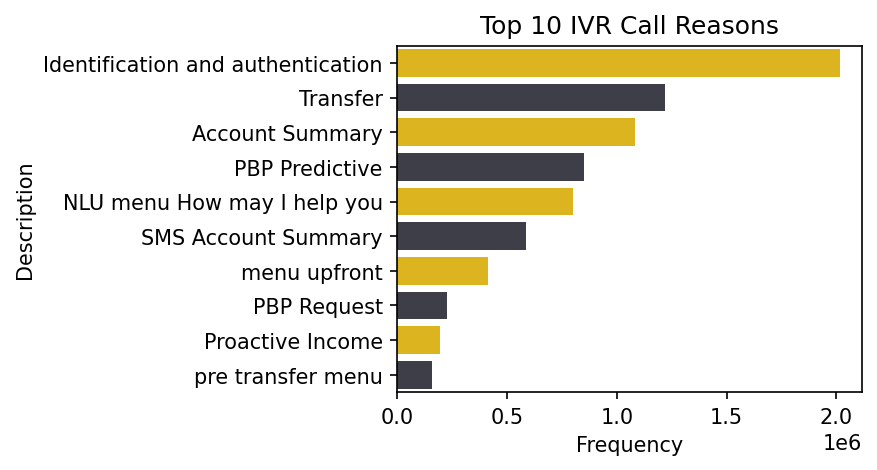

,Description,Frequency
0,Identification and authentication,2017281
2,Transfer,1219242
3,Account Summary,1084149
1,PBP Predictive,849832
5,NLU menu How may I help you,800678
4,SMS Account Summary,585427
16,menu upfront,411732
7,PBP Request,224529
14,Proactive Income,193155
10,pre transfer menu,155707


In [514]:
# Frequency Analysis of Most common Tags
list_descriptions = [item for sublist in data['mos_descriptions'].tolist() for item in sublist]

color_palette = create_range(len(list_descriptions), '#FBC600', '#3B3D49')

description_frequencies = Counter(list_descriptions)
df_frequencies = pd.DataFrame(description_frequencies.items(), columns=['Description', 'Frequency']).sort_values(by='Frequency', ascending=False)

# plot df_frequencies
plt.figure(figsize=(4, 3), dpi=150)
sns.barplot(x='Frequency', y='Description', data=df_frequencies.head(10), palette=color_palette)
plt.title('Top 10 IVR Call Reasons')
plt.show()

df_frequencies.head(10)

### **First Step: Filtering Calls that End with TRANSFER**

In [518]:
current_analysis_date = pd.Timestamp('2024-03-18')

In [519]:
data['account_open_date_13_march'] = pd.to_datetime(data['account_open_date_13_march'], errors='coerce')
data['account_open_date_18_march'] = pd.to_datetime(data['account_open_date_18_march'], errors='coerce')
data['account_age_years'] = data['account_open_date_13_march'].apply(lambda x: (current_analysis_date - x).days / 365.25)

TR_df = data[data['mos'].str.endswith('TR')]
TR_df.info(), TR_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203551 entries, 0 to 144164
Data columns (total 26 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   timestamp_call_key                 1203551 non-null  object        
 1   retailer_code                      1203551 non-null  object        
 2   serial                             1203551 non-null  int64         
 3   reason                             1203551 non-null  object        
 4   mos                                1203551 non-null  object        
 5   resolved                           1203551 non-null  object        
 6   no_of_accounts_with_syf_13_march   1200746 non-null  float64       
 7   account_balance_13_march           1132210 non-null  float64       
 8   delinquency_history_13_march       1203551 non-null  object        
 9   account_open_date_13_march         1203551 non-null  datetime64[ns]
 10  account

(None,
       timestamp_call_key retailer_code       serial reason  \
 0  240315173250 DAL1OA3M             D  10010009499     PP   
 1  240315124742 DAL15XHK             E  10006021998     BA   
 2  240317114237 DAL3BLK6             J  10016007830     PT   
 4  240314145902 DAL68RYS             I  10013002037     BA   
 5  240314151323 PHX4I30S             I  10013002037     PS   
 
                           mos  resolved  no_of_accounts_with_syf_13_march  \
 0                    IA PP TR  resolved                               1.0   
 1              IA BA TS nl TR     floor                               2.0   
 2        IA AA BA MR nl PT TR  resolved                              12.0   
 4           IA BA TS nl mm TR     floor                               6.0   
 5  IA BA TS nl PS nl mt RS TR     floor                               6.0   
 
    account_balance_13_march delinquency_history_13_march  \
 0                       NaN                         [00]   
 1                   

In [520]:
numerical_cols = ['no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march', 'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march', 'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march']
numerical_correlations = TR_df[numerical_cols].corr(method='spearman')

contingency_table = pd.crosstab(data['resolved'], data['mos'].str.endswith('TR'))
chi2, p, dof, expected = chi2_contingency(contingency_table)

numerical_correlations, contingency_table, p


(                                   no_of_accounts_with_syf_13_march  \
 no_of_accounts_with_syf_13_march                           1.000000   
 account_balance_13_march                                  -0.005983   
 eservice_ind_13_march                                      0.032919   
 auto_pay_enrolled_status_13_march                          0.008939   
 no_of_accounts_with_syf_18_march                           0.999063   
 account_balance_18_march                                  -0.005090   
 eservice_ind_18_march                                      0.030012   
 auto_pay_enrolled_status_18_march                          0.008210   
 
                                    account_balance_13_march  \
 no_of_accounts_with_syf_13_march                  -0.005983   
 account_balance_13_march                           1.000000   
 eservice_ind_13_march                             -0.051448   
 auto_pay_enrolled_status_13_march                  0.024816   
 no_of_accounts_with_syf_18_ma

In [539]:
# Replace the labels in the first column of numerical_correlation
numerical_correlations.index = ['Number of Accounts (03/13)',
                   'Account Balance (03/13)',
                   'E-Service Status (03/13)',
                   'Auto-Pay Status (03/13)',
                   'Number of Accounts (03/18)',
                   'Account Balance (03/18)',
                   'E-Service Status (03/18)',
                   'Auto-Pay Status (03/18)'] 

# Replace the columns names in the numerical_correlation
numerical_correlations.columns = ['Number of Accounts (03/13)',
                   'Account Balance (03/13)',
                   'E-Service Status (03/13)',
                   'Auto-Pay Status (03/13)',
                   'Number of Accounts (03/18)',
                   'Account Balance (03/18)',
                   'E-Service Status (03/18)',
                   'Auto-Pay Status (03/18)'] 

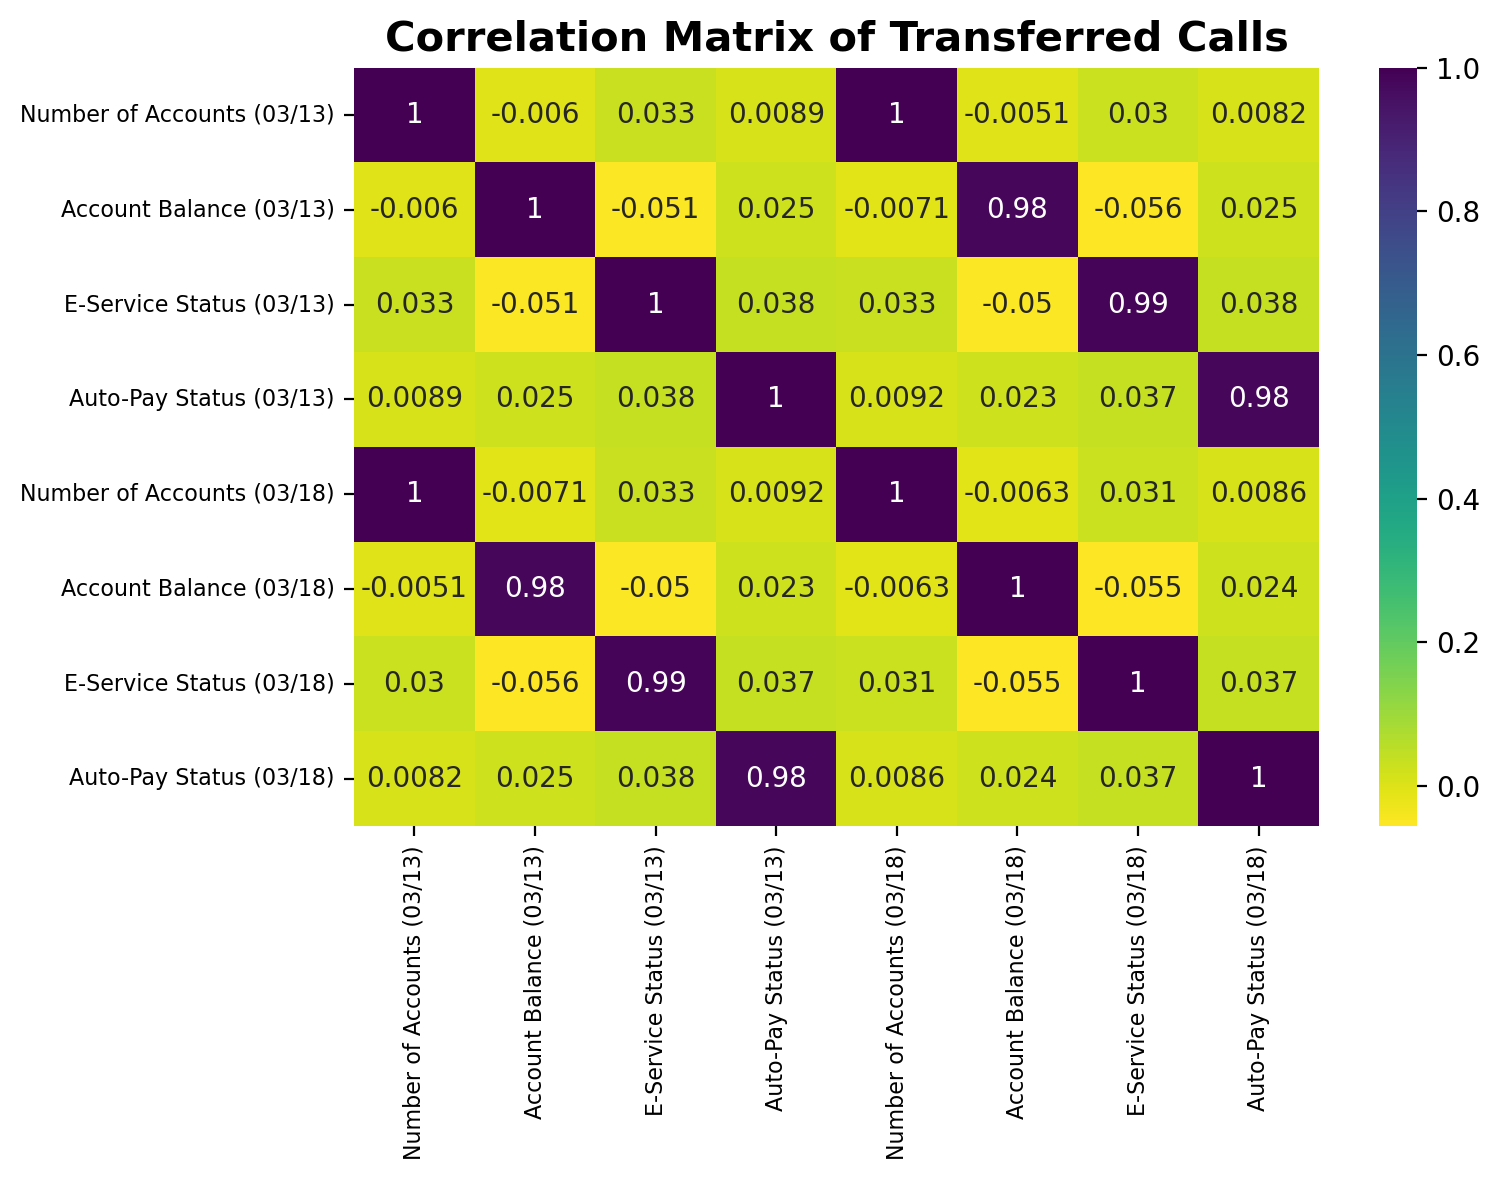

In [540]:
# Help me visualize those numerical correlations
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(numerical_correlations, annot=True, cmap='viridis_r')
plt.title('Correlation Matrix of Transferred Calls', fontweight='bold', fontsize=15)

# adjust fontsize of xticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Adjust layout to make room for the tick labels
plt.tight_layout()

plt.show()

- People with several accounts gets transferred more frequently than others.
- People with an account balance are more likely to be transferred.

In [553]:
# customize all the labels in contingency table
#invert order
contingency_table = contingency_table.reindex(index=['Floored', 'Resolved'])
contingency_table.columns = ['No Transfer', 'Transfer']
contingency_table

,No Transfer,Transfer
Floored,16140,350077
Resolved,579107,853474


Text(0.5, 1.0, 'Contingency Table ')

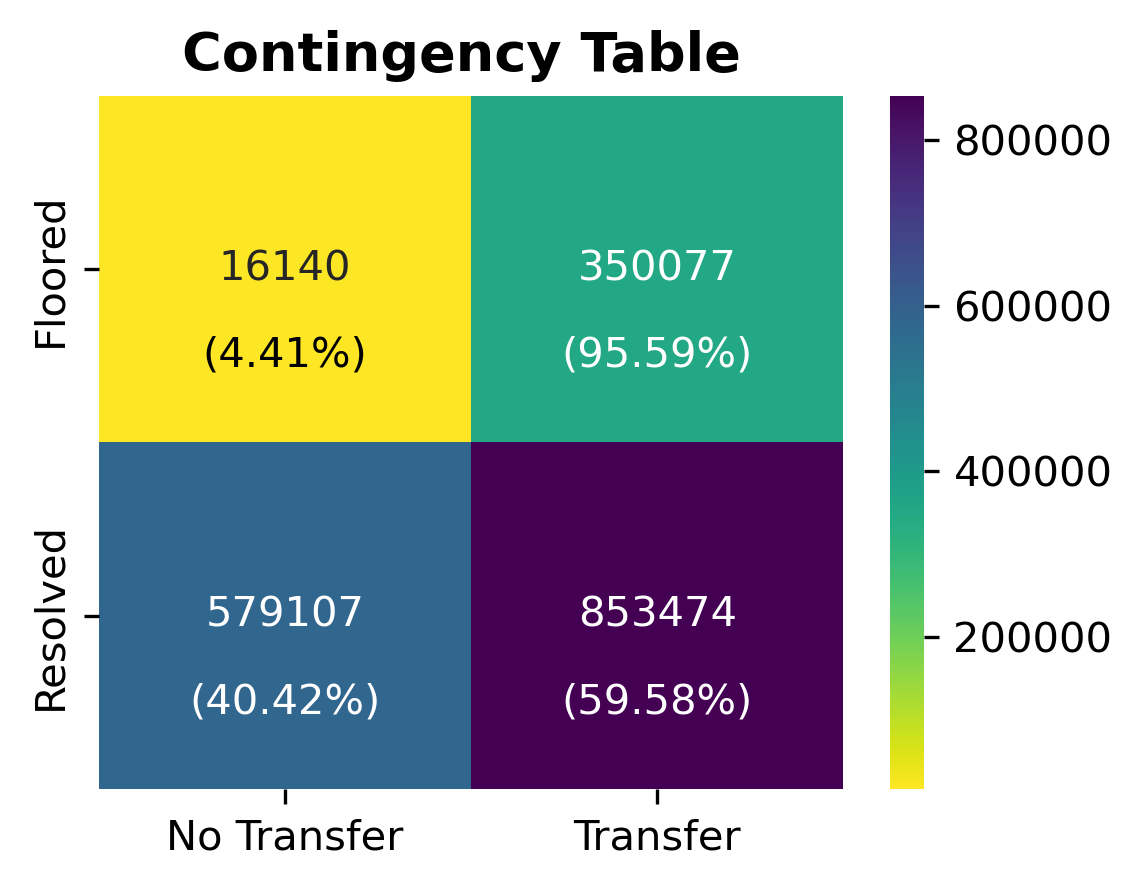

In [585]:
# Help me visualize the contingency table
plt.figure(figsize=(4, 3), dpi=300)
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='viridis_r')
# add percentage to the values (relative to the row)

color =[['black', 'white'],['white', 'white']]

for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.75, f'({contingency_table.iloc[i, j] / contingency_table.iloc[i].sum() * 100:.2f}%)', color=color[i][j], ha='center', va='center')
        
plt.title('Contingency Table ', fontweight='bold', fontsize=13)

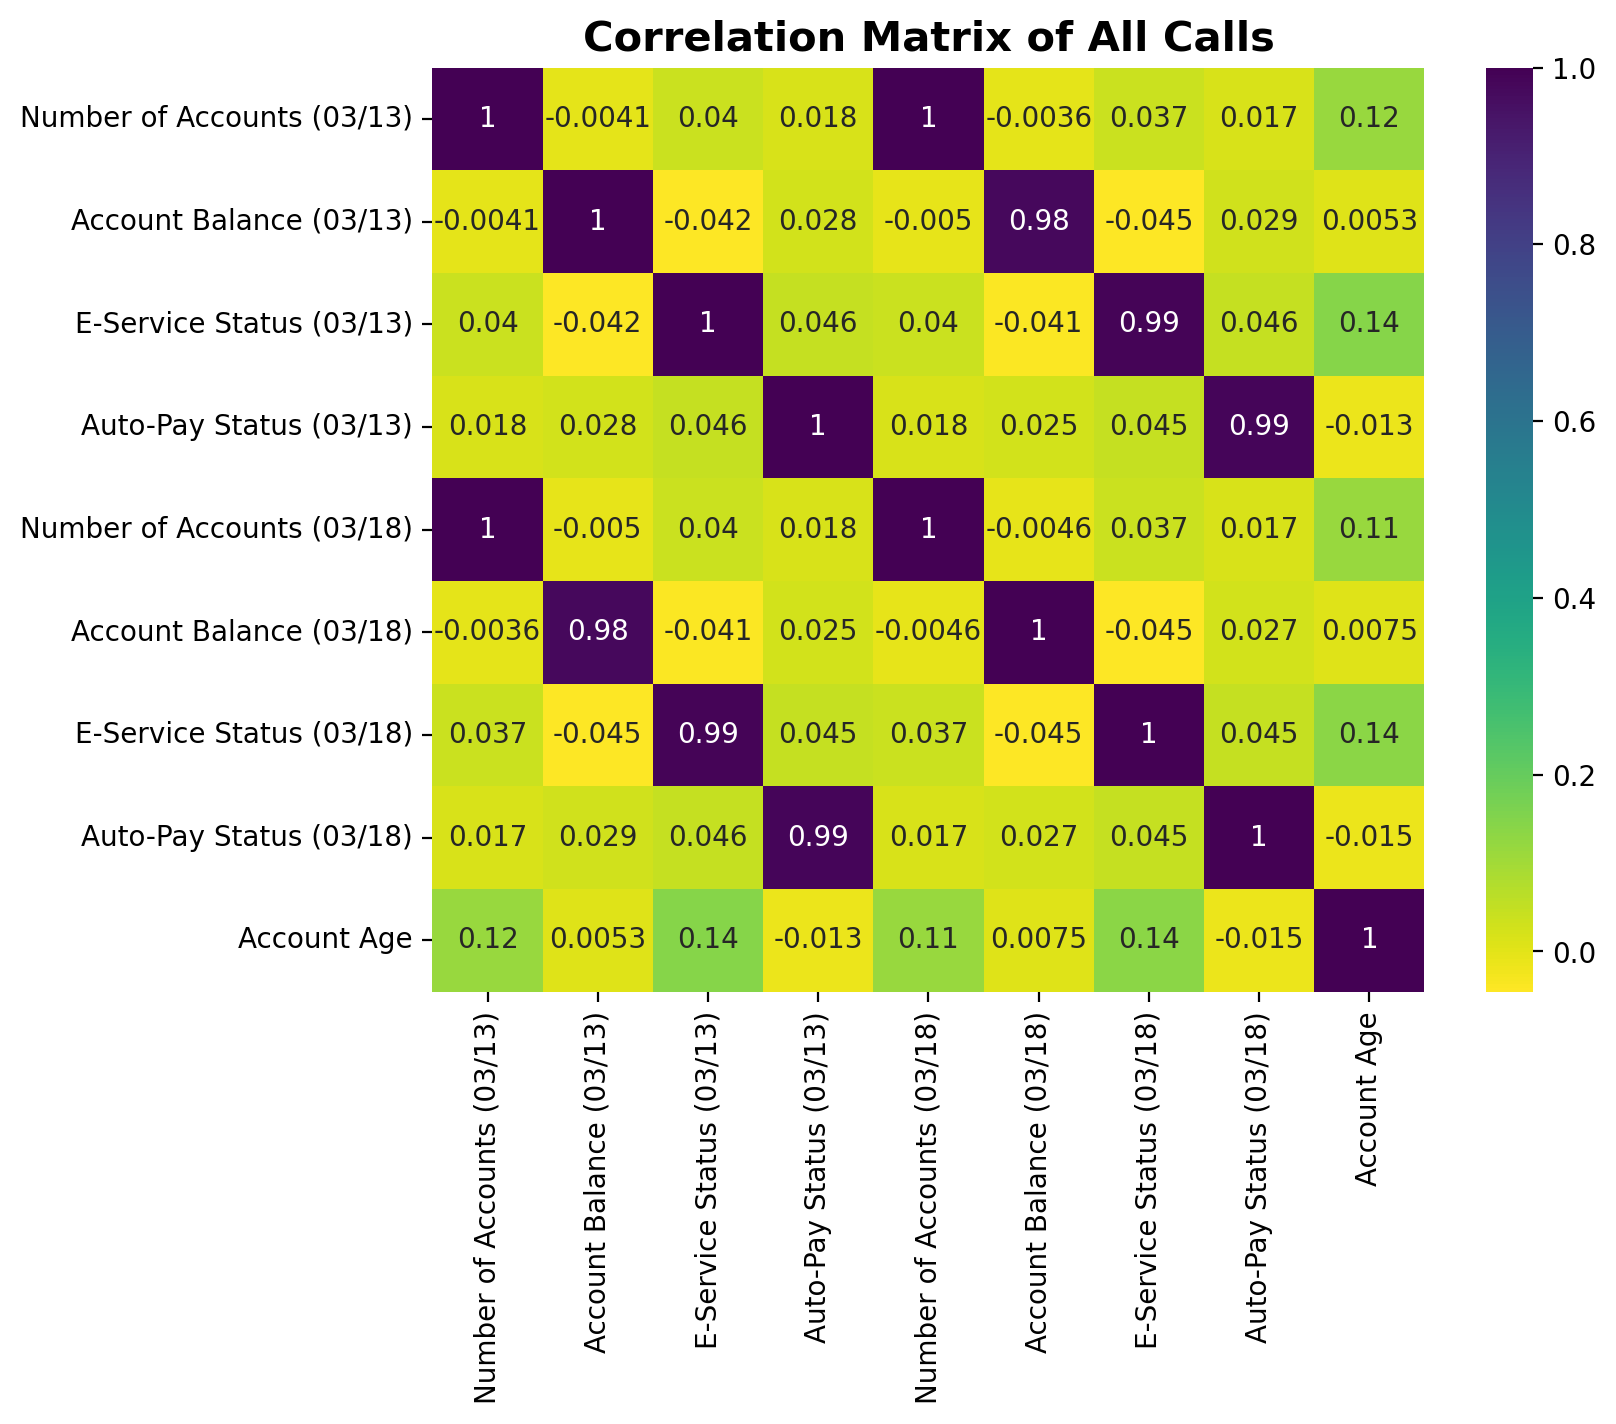

In [557]:
# Create a correlation matrix using the data df for all the variables that are numerical
numerical_cols = ['no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march', 'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march', 'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march', 'account_age_years']
numerical_correlations = data[numerical_cols].corr(method='spearman')


numerical_correlations.index = ['Number of Accounts (03/13)',
                   'Account Balance (03/13)',
                   'E-Service Status (03/13)',
                   'Auto-Pay Status (03/13)',
                   'Number of Accounts (03/18)',
                   'Account Balance (03/18)',
                   'E-Service Status (03/18)',
                   'Auto-Pay Status (03/18)',
                    'Account Age'] 

# Replace the columns names in the numerical_correlation
numerical_correlations.columns = ['Number of Accounts (03/13)',
                   'Account Balance (03/13)',
                   'E-Service Status (03/13)',
                   'Auto-Pay Status (03/13)',
                   'Number of Accounts (03/18)',
                   'Account Balance (03/18)',
                   'E-Service Status (03/18)',
                   'Auto-Pay Status (03/18)',
                    'Account Age'] 

# Help me visualize those numerical correlations
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(numerical_correlations, annot=True, cmap='viridis_r')
plt.title('Correlation Matrix of All Calls', fontweight='bold', fontsize=15)
plt.show()

## **Initial Insights**

In [558]:
# Clean Dataset

attributes_of_interest = [
    'eservice_ind_13_march', 
    'no_of_accounts_with_syf_13_march', 
    'account_age_years',
    'card_activation_status_13_march',
    'account_balance_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'auto_pay_enrolled_status_13_march',
    'delinquency_history_13_march'
]

non_numeric_attributes = [
    'eservice_ind_13_march',
    'card_activation_status_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'auto_pay_enrolled_status_13_march',
    'delinquency_history_13_march'
]

# Display unique values for these non-numeric attributes to understand their categories
non_numeric_values = {attribute: TR_df[attribute].unique() for attribute in non_numeric_attributes}


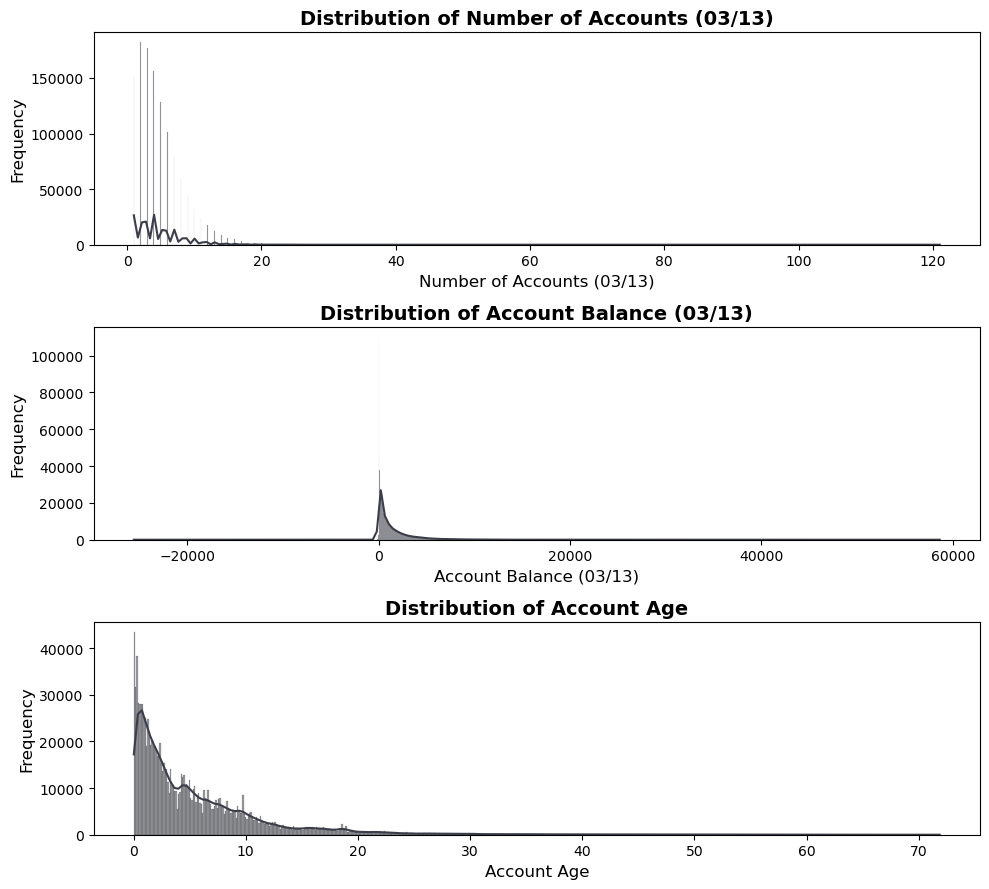

In [567]:
# Define continuous and categorical attributes after encoding.
continuous_attributes = [
    'no_of_accounts_with_syf_13_march', 
    'account_balance_13_march', 
    'account_age_years'
]

# Continuous labels
continuous_labels = [
    'Number of Accounts (03/13)',
    'Account Balance (03/13)',
    'Account Age'
]

categorical_attributes_encoded = [
    attribute + '_encoded' for attribute in non_numeric_attributes
]

# Visualize continuous attributes with distribution plots.
fig, axes = plt.subplots(nrows=len(continuous_attributes), ncols=1, figsize=(10, 3 * len(continuous_attributes)), dpi=100)
for i, attribute in enumerate(continuous_attributes):
    
    sns.histplot(TR_df[attribute], kde=True, 
                 color=synchrony[1],
                 line_kws={'color': synchrony[0]}, 
                 ax=axes[i])
    
    axes[i].set_title(f'Distribution of {continuous_labels[i]}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(continuous_labels[i], fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [586]:
label_encoder = LabelEncoder()
encoded_TR = TR_df[non_numeric_attributes].copy()
encoded_data = data[non_numeric_attributes].copy()


for attribute in non_numeric_attributes:
    # Fill NaN with a string to indicate missing data
    encoded_TR[attribute] = encoded_TR[attribute].fillna('Missing')
    encoded_data[attribute] = encoded_data[attribute].fillna('Missing')
    # Replace empty spaces with a string to indicate missing data
    encoded_TR[attribute] = encoded_TR[attribute].replace(' ', 'Missing')
    encoded_data[attribute] = encoded_data[attribute].replace(' ', 'Missing')
    # Apply label encoding
    encoded_TR[attribute] = label_encoder.fit_transform(encoded_TR[attribute])
    encoded_data[attribute] = label_encoder.fit_transform(encoded_data[attribute])

# Merge the encoded attributes back into the original DataFrame
for attribute in non_numeric_attributes:
    TR_df[attribute + '_encoded'] = encoded_TR[attribute]
    data[attribute + '_encoded'] = encoded_data[attribute]

c:\Users\johan\anaconda3\envs\alfa\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



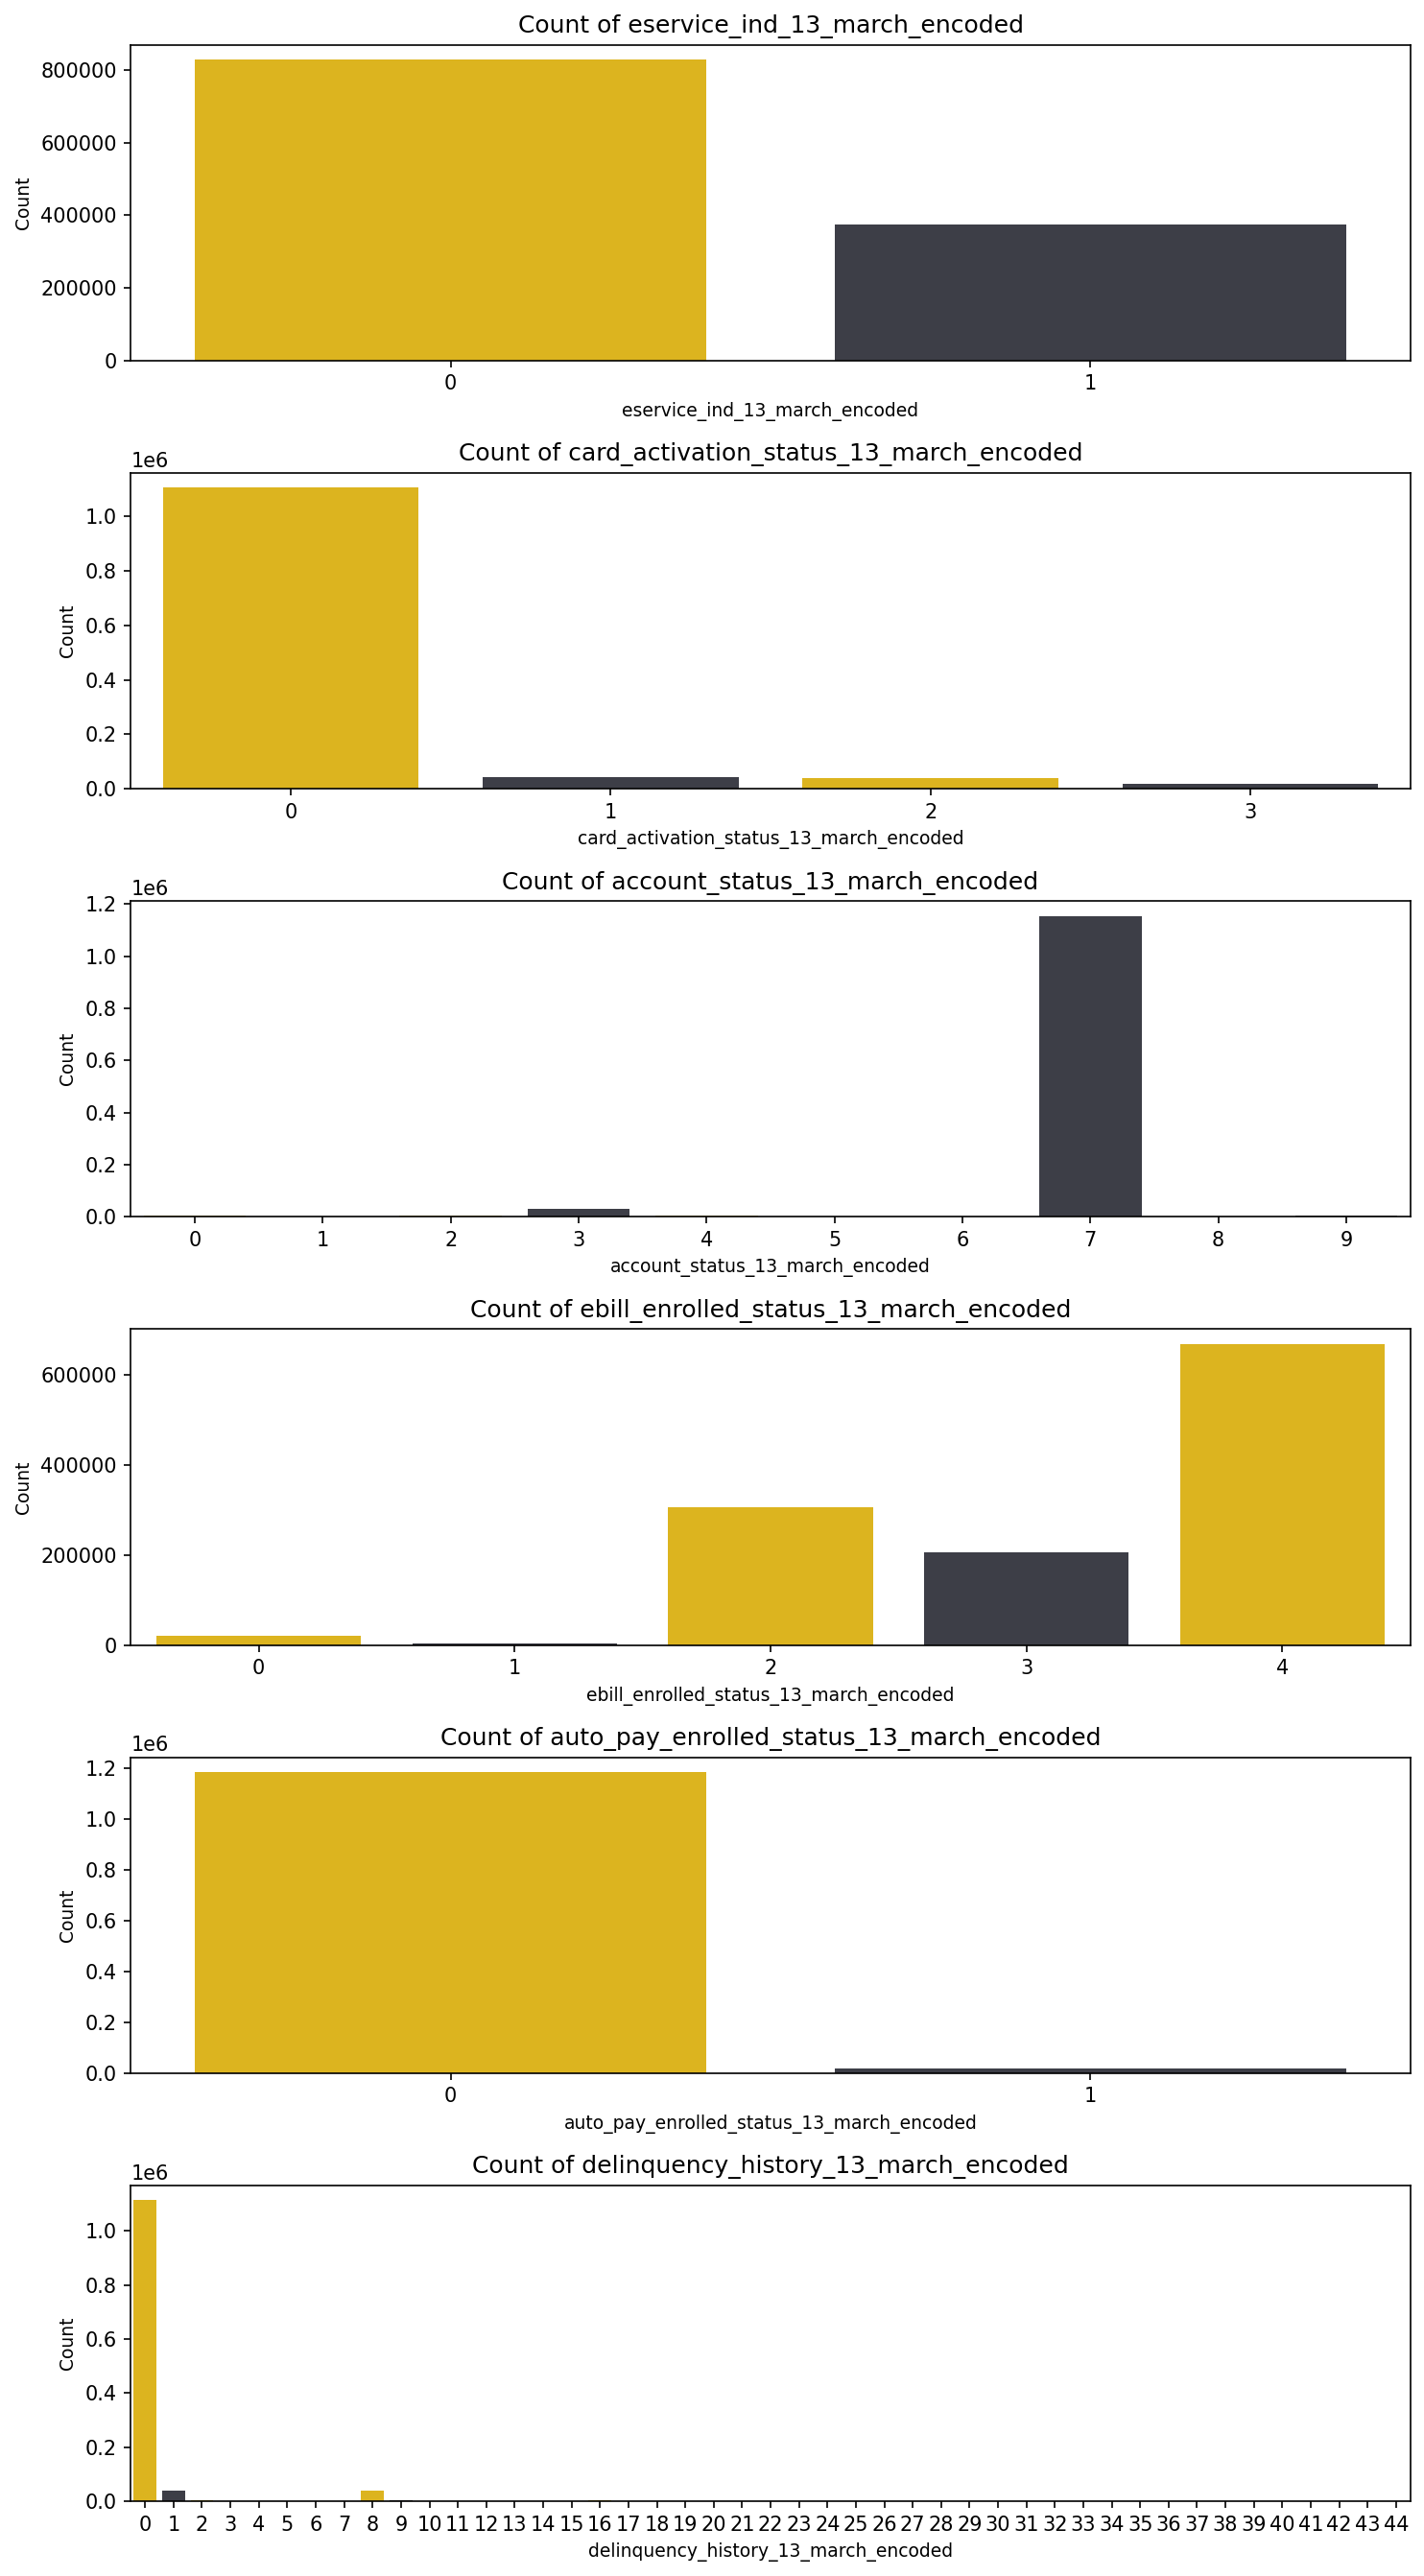

In [598]:
# Visualize categorical attributes with count plots.
fig, axes = plt.subplots(nrows=len(categorical_attributes_encoded), ncols=1, figsize=(10, 3 * len(categorical_attributes_encoded)), dpi=150)

for i, attribute in enumerate(categorical_attributes_encoded):
    color_palette = create_range(TR_df[attribute].nunique(), '#FBC600', '#3B3D49')
    sns.countplot(x=TR_df[attribute], ax=axes[i], palette=color_palette)
    axes[i].set_title(f'Count of {attribute}', fontsize=12)
    axes[i].set_xlabel(attribute, fontsize=9)
    axes[i].set_ylabel('Count', fontsize=9)
plt.tight_layout()
plt.show()

In [128]:
# Show a sample of the encoded categorical attributes
TR_df[categorical_attributes_encoded].sample(10)

,card_activation_status_13_march_encoded,account_status_13_march_encoded,ebill_enrolled_status_13_march_encoded,delinquency_history_13_march_encoded
116542,0,7,4,0
36723,0,7,4,0
84100,0,7,3,1
140412,0,7,2,0
139668,0,7,2,0
9035,0,7,4,0
148949,0,7,4,0
51831,0,7,4,1
18761,0,7,3,0
80035,0,7,3,0


In [599]:
data['mos'].str.endswith('TR').value_counts()

True     1203551
False     595247
Name: mos, dtype: int64

In [601]:
chi2_results = {}
for attribute in categorical_attributes_encoded:
    contingency_table = pd.crosstab(data[attribute], data['mos'].str.endswith('TR'))
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[attribute] = {'chi2': chi2, 'p-value': p}

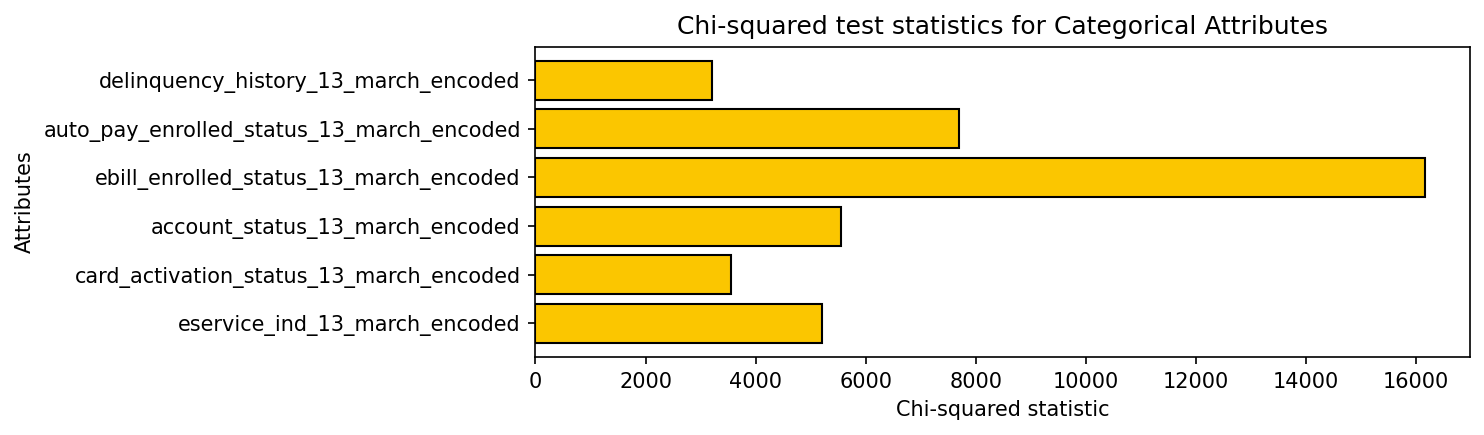

In [602]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.barh(list(chi2_results.keys()), [result['chi2'] for result in chi2_results.values()], color=synchrony[0], edgecolor='black')
ax.set_xlabel('Chi-squared statistic')
ax.set_ylabel('Attributes')
ax.set_title('Chi-squared test statistics for Categorical Attributes')
plt.tight_layout()
plt.show()

In [139]:
chi2_results

{'card_activation_status_13_march_encoded': {'chi2': 3550.502347356945,
  'p-value': 0.0},
 'account_status_13_march_encoded': {'chi2': 5550.144701882244,
  'p-value': 0.0},
 'ebill_enrolled_status_13_march_encoded': {'chi2': 16168.75647183686,
  'p-value': 0.0},
 'delinquency_history_13_march_encoded': {'chi2': 3211.77306049862,
  'p-value': 0.0}}

In [603]:
logreg_results = {}
for attribute in continuous_attributes:
    # Prepare the attribute and target variable for logistic regression
    X = data[[attribute]].fillna(0)  # Fill missing values with 0 for simplicity
    y = data['mos'].str.endswith('TR').astype(int)  # Binary outcome: transfer or not

    # Fit logistic regression model
    logreg = LogisticRegression()
    logreg.fit(X, y)

    # Store the coefficient and p-value (Wald's test)
    coef = logreg.coef_[0][0]
    intercept = logreg.intercept_[0]
    logreg_results[attribute] = {'coefficient': coef, 'intercept': intercept}

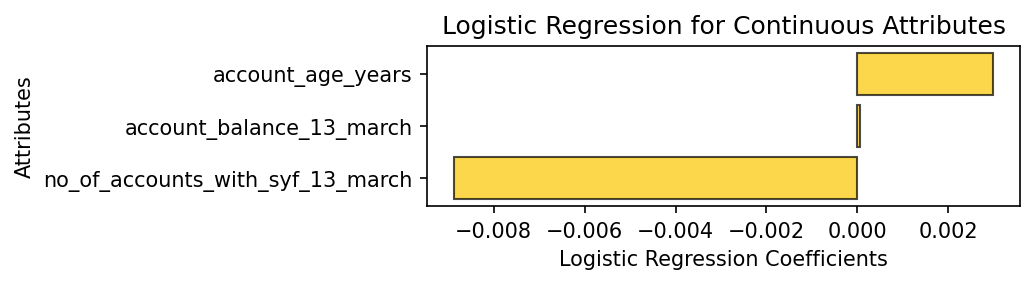

{'no_of_accounts_with_syf_13_march': {'coefficient': -0.008871424904363477,
  'intercept': 0.7479590150470027},
 'account_balance_13_march': {'coefficient': 5.876128814085534e-05,
  'intercept': 0.6339038536983295},
 'account_age_years': {'coefficient': 0.0029911452791451893,
  'intercept': 0.6878302641104669}}

In [609]:
fig, ax = plt.subplots(figsize=(7, 2), dpi=150)
ax.barh(list(logreg_results.keys()), [result['coefficient'] for result in logreg_results.values()], color=synchrony[0], alpha=0.7, edgecolor='black')
ax.set_xlabel('Logistic Regression Coefficients')
ax.set_ylabel('Attributes')
ax.set_title('Logistic Regression for Continuous Attributes')
plt.tight_layout()
plt.show()

logreg_results

## **Root Cause Analysis**

<Figure size 4000x800 with 0 Axes>

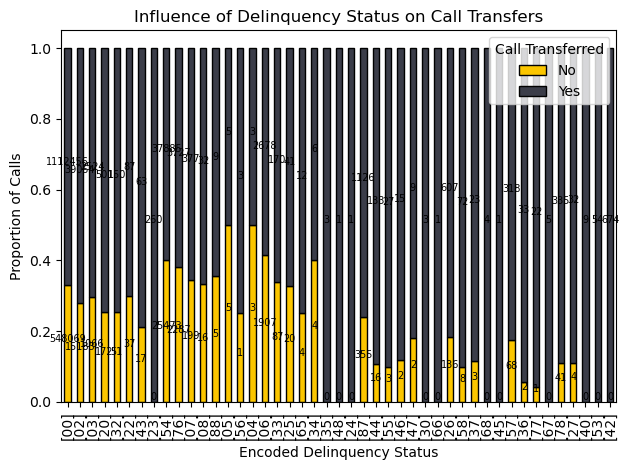

array(['[00]', '[02]', '[03]', '[20]', '[32]', '[22]', '[43]', '[23]',
       '[54]', '[76]', '[07]', '[08]', '[88]', '[05]', '[56]', '[04]',
       '[06]', '[33]', '[25]', '[65]', '[34]', '[35]', '[48]', '[24]',
       '[87]', '[44]', '[55]', '[46]', '[47]', '[30]', '[66]', '[26]',
       '[58]', '[37]', '[68]', '[45]', '[57]', '[36]', '[77]', '[67]',
       '[78]', '[27]', '[40]', '[53]', '[42]'], dtype=object)

In [610]:
# Create a crosstab of delinquency status with whether the call was transferred ('TR') or not.
delinquency_crosstab = pd.crosstab(index=data['delinquency_history_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
delinquency_crosstab_normalized = delinquency_crosstab.div(delinquency_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(20, 4), dpi=200)
delinquency_crosstab_normalized.plot(kind='bar', stacked=True, color=[synchrony[0], synchrony[1]], edgecolor='black')
plt.title('Influence of Delinquency Status on Call Transfers')
plt.xlabel('Encoded Delinquency Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Call Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(delinquency_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['delinquency_history_13_march'].unique())), labels=data['delinquency_history_13_march'].unique())
plt.tight_layout()
plt.show()

data['delinquency_history_13_march'].unique()


<Figure size 1200x800 with 0 Axes>

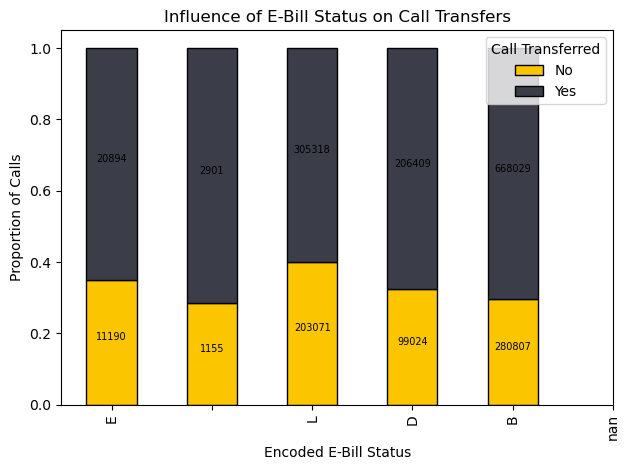

array(['E', ' ', 'L', 'D', 'B', nan], dtype=object)

In [611]:
ebill_crosstab = pd.crosstab(index=data['ebill_enrolled_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
ebill_crosstab_normalized = ebill_crosstab.div(ebill_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(6, 4), dpi=200)
ebill_crosstab_normalized.plot(kind='bar', stacked=True, color=[synchrony[0], synchrony[1]], edgecolor='black')
plt.title('Influence of E-Bill Status on Call Transfers')
plt.xlabel('Encoded E-Bill Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Call Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(ebill_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['ebill_enrolled_status_13_march'].unique())), labels=data['ebill_enrolled_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['ebill_enrolled_status_13_march'].unique()

<Figure size 1600x800 with 0 Axes>

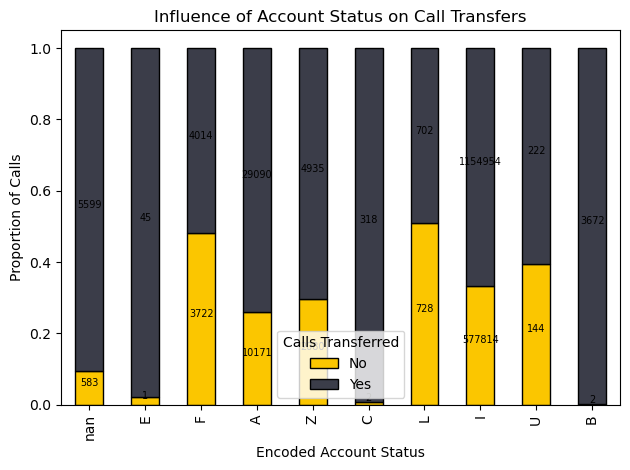

array([nan, 'E', 'F', 'A', 'Z', 'C', 'L', 'I', 'U', 'B'], dtype=object)

In [612]:
account_crosstab = pd.crosstab(index=data['account_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
account_crosstab_normalized = account_crosstab.div(account_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(8, 4), dpi=200)
account_crosstab_normalized.plot(kind='bar', stacked=True, color=[synchrony[0], synchrony[1]], edgecolor='black')
plt.title('Influence of Account Status on Call Transfers')
plt.xlabel('Encoded Account Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Calls Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(account_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)


plt.xticks(ticks=range(len(data['account_status_13_march'].unique())), labels=data['account_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['account_status_13_march'].unique()

<Figure size 1200x800 with 0 Axes>

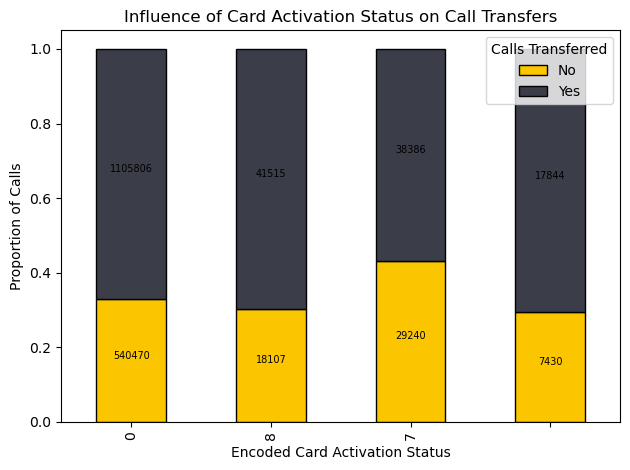

array(['0', '8', '7', ' '], dtype=object)

In [613]:
activation_crosstab = pd.crosstab(index=data['card_activation_status_13_march_encoded'],
                                   columns=data['mos'].str.endswith('TR'))

# Normalize the crosstab to get proportions rather than counts
activation_crosstab_normalized = activation_crosstab.div(activation_crosstab.sum(1), axis=0)

# Create a bar chart
plt.figure(figsize=(6, 4), dpi=200)
activation_crosstab_normalized.plot(kind='bar', stacked=True, color=[synchrony[0], synchrony[1]], edgecolor='black')
plt.title('Influence of Card Activation Status on Call Transfers')
plt.xlabel('Encoded Card Activation Status')
plt.ylabel('Proportion of Calls')
plt.legend(title='Calls Transferred', labels=['No', 'Yes'])

# Add labels on top of the bars
for i, (index, row) in enumerate(activation_crosstab.iterrows()):
    yes_height = row[True]
    no_height = row[False]
    total = yes_height + no_height
    plt.text(i, (no_height/total) + (yes_height/total)/2, f'{yes_height}', ha='center', va='bottom', fontsize=7)
    plt.text(i, (no_height/total)/2, f'{no_height}', ha='center', va='bottom', fontsize=7)

plt.xticks(ticks=range(len(data['card_activation_status_13_march'].unique())), labels=data['card_activation_status_13_march'].unique())
plt.tight_layout()
plt.show()

data['card_activation_status_13_march'].unique()

Ranking is:
- [0] Activated cards
- [8] SYF sent constumer a new plastic card with the same account number
- [7] SYF sent customer a new plastic card with a different account number
- [blank] Card does not need to be activated

## **Customer Journey Mapping**

In [627]:
transition_counts = defaultdict(int)
for sequence in TR_df['mos']:
    codes = sequence.split()  # Assuming codes in 'mos' are space-separated
    for i in range(len(codes) - 1):
        transition_counts[(codes[i], codes[i+1])] += 1

# Map the transitions to sources and targets for the Sankey diagram
sources = []
targets = []
values = []
labels = []
label_to_index = {}

# Assign an index to each unique code and fill sources, targets, and values
for (source, target), count in transition_counts.items():
    if source not in label_to_index:
        label_to_index[source] = len(labels)
        labels.append(source)
    if target not in label_to_index:
        label_to_index[target] = len(labels)
        labels.append(target)
    
    sources.append(label_to_index[source])
    targets.append(label_to_index[target])
    values.append(count)

In [629]:
num_categories = len(labels)
viridis = plt.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, num_categories))
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# Define the Sankey diagram with the generated color palette
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=5,  # Spacing between nodes
        thickness=1,  # Thickness of the nodes
        line=dict(color="black", width=0.5),  # Border line color and width
        label=labels,
        color=hex_colors  # Assign generated colors to the nodes
    ),
    link=dict(
        source=sources,  # Source node indices
        target=targets,  # Target node indices
        value=values,  # Volume of flow between nodes
        color=hex_colors  # Assign generated colors to the links
    )
)])

# Update layout for a better look and high resolution
fig.update_layout(
    title_text="Customer Journey Mapping through IVR leading to CS Transfer",
    font_size=16,  # Adjust font size
    width=2400,  # Width of the figure
    height=1200,  # Height of the figure
    paper_bgcolor='white',  # Background color of the figure
)

#visualize online as html
fig.write_html("Sankey.html")

In [625]:
sequences = data['mos'].str.split()
sequence_counts = Counter([tuple(sequence) for sequence in sequences])
top_sequences = sequence_counts.most_common(5)

sources, targets, values = [], [], []

# Map for sequence steps to node indices
node_map = {}
current_index = 0


num_categories = len(categorical_attributes_encoded)
viridis = plt.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, num_categories))
hex_colors = [mcolors.rgb2hex(color) for color in colors]


for sequence, count in top_sequences:
    for i in range(len(sequence) - 1):
        # Check if the source node exists, if not add it
        if sequence[i] not in node_map:
            node_map[sequence[i]] = current_index
            current_index += 1
        # Check if the target node exists, if not add it
        if sequence[i+1] not in node_map:
            node_map[sequence[i+1]] = current_index
            current_index += 1
            
        sources.append(node_map[sequence[i]])
        targets.append(node_map[sequence[i+1]])
        values.append(count)

# Create labels from node_map
labels = list(node_map.keys())

# Define the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=hex_colors  # Assign generated colors to the nodes
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=hex_colors  # Assign generated colors to the links
    )
)])

# Update layout for a better look
fig.update_layout(
    title_text="Top 5 Most Frequent Sequences in IVR Calls",
    font_size=14,
    width=800,
    height=600
)

# Show the figure
fig.show()
fig.write_html("Sankey_Top5.html")

## **Understanding Variables**

In [630]:
data['account_status_13_march'] = data['account_status_13_march'].fillna('O')
TR_df['account_status_13_march'] = TR_df['account_status_13_march'].fillna('O')

c:\Users\johan\anaconda3\envs\alfa\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### **a) Digitally Active (eservice_ind = 1)**

Chi-squared Test: chi2=6626.996401976838, p-value=0.0


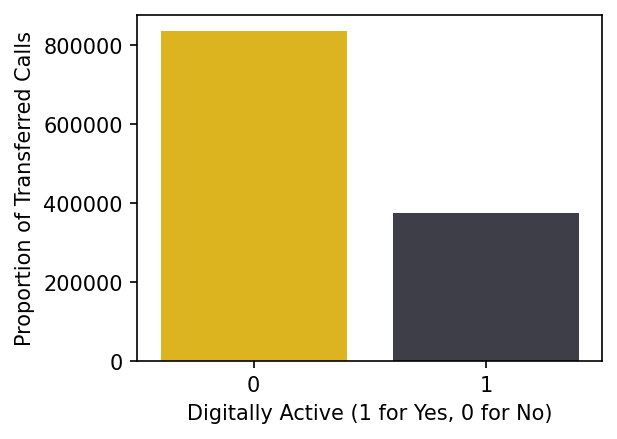

In [669]:
digital_transfer = TR_df['eservice_ind_13_march'].value_counts(normalize=True)
crosstab = pd.crosstab(data['eservice_ind_13_march'], data['mos'].str.contains('TR'))

# Perform a chi-squared test to examine the association
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f'Chi-squared Test: chi2={chi2}, p-value={p}')

fig = plt.figure(figsize=(4, 3), dpi=150)
sns.barplot(x=crosstab.index, y=crosstab[True], palette=synchrony)
# plt.title('Proportion of Transferred Calls - Digitally Active vs. Inactive')
plt.xlabel('Digitally Active (1 for Yes, 0 for No)')
plt.ylabel('Proportion of Transferred Calls')
plt.show()

#### **h) Auto-Pay Enrolled Status:**

Chi-squared Test: chi2=6805.280933188331, p-value=0.0


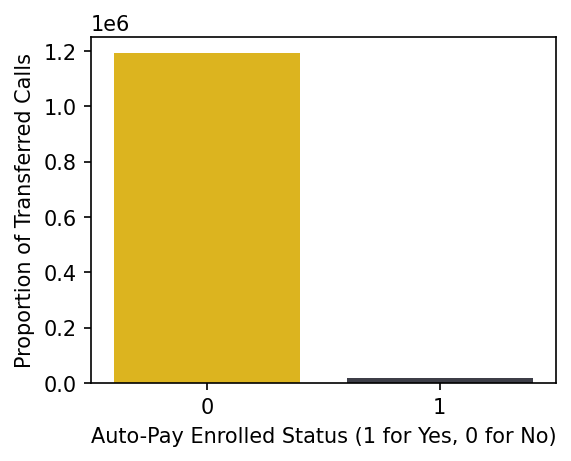

In [668]:
crosstab = pd.crosstab(data['auto_pay_enrolled_status_13_march'], data['mos'].str.contains('TR'))

# Perform a chi-squared test to examine the association
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f'Chi-squared Test: chi2={chi2}, p-value={p}')

fig = plt.figure(figsize=(4, 3), dpi=150)
sns.barplot(x=crosstab.index, y=crosstab[True], palette=synchrony)
#plt.title('Proportion of Transferred Calls - Auto-Pay Enrolled Status')
plt.xlabel('Auto-Pay Enrolled Status (1 for Yes, 0 for No)')
plt.ylabel('Proportion of Transferred Calls')
plt.show()

c:\Users\johan\anaconda3\envs\alfa\lib\site-packages\ipykernel_launcher.py:55: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



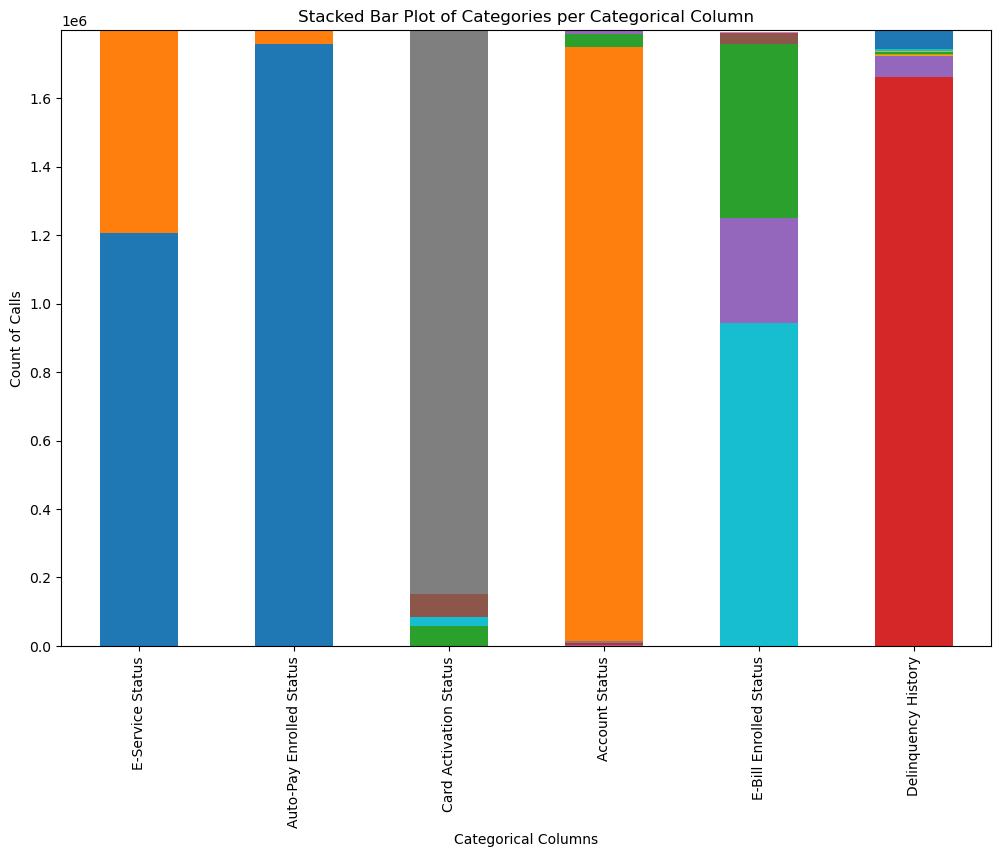

In [633]:
columns_to_plot = [
    'eservice_ind_13_march', 
    'auto_pay_enrolled_status_13_march',
    'card_activation_status_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'delinquency_history_13_march'
]

columns_labels = [
    'E-Service Status',
    'Auto-Pay Enrolled Status',
    'Card Activation Status',
    'Account Status',
    'E-Bill Enrolled Status',
    'Delinquency History'
]

category_counts = {}

for column in columns_to_plot:
    category_counts[column] = data[column].value_counts()

# Get the unique categories across all columns to define the DataFrame structure
all_categories = set()
for counts in category_counts.values():
    all_categories.update(counts.index)

# Initialize the DataFrame with zeros
combined_df = pd.DataFrame(0, index=all_categories, columns=columns_to_plot)

# Fill the DataFrame with the counts
for column, counts in category_counts.items():
    combined_df[column] = counts

# Transpose the DataFrame to have columns as x-ticks
combined_df = combined_df.T
# Initialize a figure


plt.figure(figsize=(12, 8))
combined_df.plot(kind='bar', stacked=True, ax=plt.gca())

#update column labels
plt.gca().set_xticklabels(columns_labels, rotation=0)

# Add labels and title
plt.title('Stacked Bar Plot of Categories per Categorical Column')
plt.xlabel('Categorical Columns')
plt.ylabel('Count of Calls')

# Rotate x-tick labels for better readability
plt.xticks(rotation=90)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

#remove legend
plt.legend().remove()

# Show the plot
plt.show()

In [315]:
# Show unique values of the account_status_13_march column
data['account_status_13_march'].unique()

array([nan, 'E', 'F', 'A', 'Z', 'C', 'L', 'I', 'U', 'B'], dtype=object)

In [665]:
import plotly.graph_objects as go
import pandas as pd


# Assuming 'data' is your DataFrame already loaded with the necessary columns
columns_to_plot = [
    'eservice_ind_13_march',
    'auto_pay_enrolled_status_13_march',
    'card_activation_status_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'delinquency_history_13_march'
]


viridis = plt.get_cmap('viridis_r')
colors = viridis(np.linspace(0.025, 1, 6, endpoint=True))
color_palette = [mcolors.rgb2hex(color) for color in colors]

fig = go.Figure()

for i, column in enumerate(columns_to_plot):
    value_counts = TR_df[column].value_counts(normalize=False)
    stack_bottom = 0
    
    for j, (value, count) in enumerate(value_counts.items()):
        # Use modulo to cycle through the color palette if there are more categories than colors
        color = color_palette[j % len(color_palette)]
        
        # Add a bar for this category
        fig.add_trace(go.Bar(
            name=f"{value}",  # Name shows column and category value
            x=[column],  # X-axis position is the column name
            y=[count],  # Bar segment height
            marker_color=color,  # Color for this segment
            offset=-0.35,  # Align bars directly under column names
            base=[stack_bottom],  # Start the stack from the last height
            text=value,
            textposition='inside',
            textfont=dict(size=18),
            hoverinfo="y+name",  # Show count and name on hover
            # hoverinfo should be count and subcategory
        ))
        
        # Update the bottom of the stack for the next category
        stack_bottom += count

# Update layout for stacked bars
fig.update_layout(
    barmode='stack',
    #title_text='Counts of Unique Values in Categorical Columns',
    title_font=dict(size=24, family='Calibri, bold'),
    xaxis=dict(
        title='Categorical Columns',
        title_font=dict(size=24, family='Calibri, bold'),
        tickfont=dict(size=14),
        type='category'  # Ensure x-axis is treated as categories, not numerical
    ),
    yaxis=dict(
        title='Number of Occurrences',
        title_font=dict(size=24, family='Calibri, bold'),
        tickfont=dict(size=14)
    ),
    legend_title='<b>Categories</b>',
    legend_title_font=dict(size=16, family='Calibri, bold'),
    legend_font=dict(size=14),
    autosize=True,
    width=1200,
    height=800
)

#rotate xticks
fig.update_xaxes(tickangle=0,tickvals=columns_to_plot, ticktext=[
    'E-Service Status',
    'Auto-Pay Enrolled Status',
    'Card Activation Status',
    'Account Status',
    'E-Bill Enrolled Status',
    'Delinquency History'
]

)

#sett all fonts as black 
fig.update_layout(font=dict(color="black"))
# Set line color and width for bar borders
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.update_layout(showlegend=False)

fig.show()
